In [38]:
require(data.table)
require(dada2)
require(phyloseq)
require(ggplot2)
require(RColorBrewer)
library("DESeq2")
options(repr.plot.width=20, repr.plot.height=15)

In [2]:
meta=fread("~/Documents/DE/DE_16S/DE16S_allmeta.csv")
asv_all=fread("~/Documents/DE/DE_16S/ASVs/Run123_ASV_nochim.csv")
taxa=read.csv("~/Documents/DE/DE_16S/ASVs/Run123_taxa.csv", header=TRUE, row.names=1)

In [3]:
#fix rownames
rows=as.vector(asv_all[,1])
asv_all=asv_all[,-1]
asv_all=apply(asv_all, 2, as.numeric)
row.names(asv_all)=rows$V1

In [4]:
#pull out the dilution effect samples
meta_de=meta[meta$Experiment=="Field17"|meta$Experiment=="Lab18",]

In [5]:
asv_de=asv_all[rownames(asv_all) %in% meta_de$UniqueID,]

In [6]:
asv_de=asv_de[,colSums(asv_de)>0]

In [7]:
taxa_de=taxa[rownames(taxa)%in% colnames(asv_de),]
taxa_de=as.matrix(taxa_de)

In [8]:
taxa_de=as.matrix(taxa_de)
meta_de=as.data.frame(meta_de)
row.names(meta_de)=meta_de$UniqueID

In [29]:
OTU = otu_table(t(asv_de), taxa_are_rows = TRUE)
TAX = tax_table(taxa_de)
SAMP=sample_data(meta_de)

In [32]:
SAMP$peacrabs=factor(SAMP$peacrabs)

In [33]:
SAMP$RFTM_score=factor(SAMP$RFTM_score)

In [123]:
SAMP$RFTM_simp=SAMP$RFTM_score

In [126]:
SAMP$RFTM_simp=sub("0.5", "1", SAMP$RFTM_simp)
SAMP$RFTM_simp=sub("5", "4", SAMP$RFTM_simp)

In [136]:
SAMP$RFTM_simp=factor(SAMP$RFTM_simp)

In [137]:
OTU=transform_sample_counts(OTU, function(x) 1000000 * x/sum(x))

In [138]:
DE = phyloseq(OTU, TAX, SAMP)

In [139]:
DE17=subset_samples(DE, Year=="2017")
DE18=subset_samples(DE, Year=="2018")

In [140]:
sample_variables(DE17)

[1] "V1"                   "UniqueID"             "Experiment"          
 [4] "Year"                 "Site"                 "Treatment1_Density"  
 [7] "Treatment2_Diversity" "Color_Bucket"         "Number"              
[10] "Species"              "RFTM_score"           "peacrabs"            
[13] "Phase_1_DO"           "Phase_1_temp"         "Phase_2_DO"          
[16] "Phase_2_Temp"         "Overall_treatment"    "RFTM_simp"

In [141]:
DE17ddsrftm = phyloseq_to_deseq2(DE17, ~ Site+RFTM_simp)
DE17ddsrftm = DESeq(DE17ddsrftm, test="Wald", fitType="parametric")


converting counts to integer mode

Warning message in DESeqDataSet(se, design = design, ignoreRank):
“some variables in design formula are characters, converting to factors”
estimating size factors

estimating dispersions

gene-wise dispersion estimates

mean-dispersion relationship

-- note: fitType='parametric', but the dispersion trend was not well captured by the
   function: y = a/x + b, and a local regression fit was automatically substituted.
   specify fitType='local' or 'mean' to avoid this message next time.

final dispersion estimates

fitting model and testing

-- replacing outliers and refitting for 7629 genes
-- DESeq argument 'minReplicatesForReplace' = 7 
-- original counts are preserved in counts(dds)

estimating dispersions

fitting model and testing



In [176]:
res01 = results(DE17ddsrftm, contrast=c("RFTM_simp", "0", "1"))
alpha = 0.05
sig01 = res01[which(res01$padj < alpha), ]
sig01 = cbind(as(sig01, "data.frame"), as(tax_table(DE17)[rownames(sig01), ], "matrix"))
sig01_pos=sig01[sig01$log2FoldChange>0,]

In [178]:
res12 = results(DE17ddsrftm, contrast=c("RFTM_simp", "1", "2"))
alpha = 0.05
sig12 = res01[which(res12$padj<alpha),]
sig12 = cbind(as(sig12,"data.frame"), as(tax_table(DE17)[rownames(sig12), ], "matrix"))
sig12_pos=sig12[sig12$log2FoldChange>0,]

In [179]:
res23 = results(DE17ddsrftm, contrast=c("RFTM_simp", "2", "3"))
alpha = 0.05
sig23 = res23[which(res23$padj<alpha),]
sig23 = cbind(as(sig23,"data.frame"), as(tax_table(DE17)[rownames(sig23), ], "matrix"))
sig23_pos=sig23[sig23$log2FoldChange>0,]

In [180]:
res34 = results(DE17ddsrftm, contrast=c("RFTM_simp", "3", "4"))
alpha = 0.05
sig34 = res34[which(res34$padj<alpha),]
sig34 = cbind(as(sig34,"data.frame"), as(tax_table(DE17)[rownames(sig34), ], "matrix"))
sig34_pos=sig34[sig34$log2FoldChange>0,]

In [183]:
sig012_pos=merge(sig01_pos, sig12_pos, by=c("row.names", 'Kingdom','Phylum','Class','Order','Family','Genus'))

In [188]:
rownames(sig012_pos)=sig012_pos$Row.names

In [189]:
sig0123_pos=merge(sig012_pos, sig23_pos, by=c("row.names", 'Kingdom','Phylum','Class','Order','Family','Genus'))

Warning message in merge.data.frame(sig012_pos, sig23_pos, by = c("row.names", "Kingdom", :
“column name ‘Row.names’ is duplicated in the result”


In [190]:
rownames(sig0123_pos)=sig0123_pos$Row.names

In [191]:
sig01234_pos=merge(sig0123_pos, sig34_pos, by=c("row.names", 'Kingdom','Phylum','Class','Order','Family','Genus'))

Warning message in merge.data.frame(sig0123_pos, sig34_pos, by = c("row.names", :
“column names ‘Row.names’, ‘Row.names’, ‘baseMean.x’, ‘log2FoldChange.x’, ‘lfcSE.x’, ‘stat.x’, ‘pvalue.x’, ‘padj.x’, ‘baseMean.y’, ‘log2FoldChange.y’, ‘lfcSE.y’, ‘stat.y’, ‘pvalue.y’, ‘padj.y’ are duplicated in the result”


In [195]:
sig34_pos

baseMean  
CACGGGTCGATACAGTGTTTCGCAGCTTGATTAGGTGTAAATGTAATAAGGCGTATTAGGTAGTAATTGGTTTGTTGTTGATTTTTTAGTTATTTTTATATCTTTTTTCTTCATGTGAAATCGTAATTAGTAAAGTTATTGTGATATGAAGAATACCTTCTTATTGGTTTAAAAGGATGTTTGTAGGGTTTTTATATTTAGGAAAACAAAGCCGTAGAGATTAGAAAACCTTCCGAATGTGGAGACGACAAACAATTTTTAATCGACGCTGAATTTACTAAAGCAGGGGTAGCGAGAAAG                                                                                                                             92.84791
TACGGAGGGTGCAAGCGTTAATCGGAATTACTGGGCGTAAAGCGCACGCAGGCGGTTGGATAAGTTAGATGTGAAAGCCCCGGGCTCAACCTGGGAATTGCATTTAAAACTGTCCAGCTAGAGTCTTGTAGAGGGGGGTAGAATTCCAGGTGTAGCGGTGAAATGCGTAGAGATCTGGAGGAATACCGGTGGCGAAGGCGGCCCCCTGGACAAAGACTGACGCTCAGGTGCGAAAGCGTGGGGAGCAAACAGG                                                                                                                                                                          1549.64101
TACGTATGTCGCAAGCGTTATCCGGAATTATTGGGCGTAAAGCGAGTCTAGGCGGTTTGTTAAGTCAGATGTGAAAATGCGGGGCTCAACTCCGTATGGCCTTTGATACTGGCAAACTAGAGTACTGGAGAGGTGGGCGGAACTACAAGTGTAGAGGTGAAATTCGTAGATATTTGTAGGAATGCCGATAGTGAAGACAGCTCACTGGACAGATACTGACGCTAAAGCTCGAAAGCGTGGGGAGCGAACAGG                                                                                                                                                                           6753.88993
TACGGAGGGTGCAAGCGTTAATCGGAATTACTGGGCGTAAAGCGCGCGTAGGTGGCTAAGTCAGCCAGGTGTGAAAGCCCCGGGCTCAACCTGGGAACGGCATCTGGAACTGCTTGGCTAGAGTGCAGGAGAGGAAGGTAGAATTCCCGGTGTAGCGGTGAAATGCGTAGAGATCGGGAGGAATACCAGTGGCGAAGGCGGCCTTCTGGACTGACACTGACACTGAGGTGCGAAAGCGTGGGTAGCAAACAGG                                                                                                                                                                          1170.63334
TACGGGAAGGGCTAGCGTTATTCAAAATTACTGGGCGTAAAGAGTTCGTAGGCTGTTTTGTAAGTTATATTTAAAATTTATAGATTAGATTTAAAAGTTTTATAATACTACAAAACTAGAGTTTTATTTAGAAGAATAGAATTTTTTGAGGAGAGATAAAATTCGTAGATTTTTAAAGGAATACCTTATAGTGAAAACAATTCTTTATTAAAAACTGACGTTGAGGAACGAAAGTATAGGTAGCAAACAGG                                                                                                                                                                            2721.02737
TACGAAAGGTGCAAACGTTGTTCGGAATCACTGGGCGTAAAGCGCACGTAGGCGGGCTTTTAAGTCGATTGTGAAATCCCAGGGCTTAACCTTGGAACTGCAGTCGAAACTGGAAGTCTTGAATATCTGAGAGGTTGGGGGAATTCCTGGTGGAGAAGTGAAATTCGTAGATATCAGGAGGAACACCGGAGGCGAAGGCGCCTGACTGGCAGAATATTGACGCTGATGTGCGAAAGCGTGGGGAGCAAACAGG                                                                                                                                                                           821.66236
TACGGAGGGTGCGAGCGTTAATCGGAATTACTGGGCGTAAAGCGTACGCAGGCGGTTTGTTAAGCGAGATGTGAAAGCCCCGGGCTCAACCTGGGAACTGCATTTCGAACTGGCAAACTAGAGTGTGATAGAGGGTGGTAGAATTTCAGGTGTAGCGGTGAAATGCGTAGAGATCTGAAGGAATACCGATGGCGAAGGCAGCCACCTGGGTCAACACTGACGCTCATGTACGAAAGCGTGGGGAGCAAACGGG                                                                                                                                                                          1061.70008
GACGGAGGATGCAAGTGTTATCCGGAATCACTGGGCGTAAAGCGTCTGTAGGTGGTTTAATAAGTCAACTGTTAAATCTTGAGGCTCAACCTCAAAATCGCAGTCGAAACTATTAGACTAGAGTATAGTAGGGGTAAAGGGAATTTCCAGTGGAGCGGTGAAATGCGTAGAGATTGGAAAGAACACCGATGGCGAAGGCACTTTACTGGGCTATTACTAACACTCAGAGACGAAAGCTAGGGTAGCAAATGGG                                                                                                                                                                           420.22965
TACGGGAGGGGCAAGCGTTATCCAGATTGATTGGGCGTAAAGGGTTCGTAGACGGTACAGTAAGTTATTTGTTAAATATTAAAGCCTAACTTTAAAAAAACATTTAAAACTGCTTTACTTTGAGTTTTAAACAGAAGAGTAGAATTTTATAAGAAGGGATAAAATCTGAAGATATGTAAAGGAATATCGATAGTGAAGACAACTCTTTAGTAAAAACTGACGTTGAGGGACGAAAGTGTAGGGAGCAAATAGG                                                                                                                                                                           183.97282
TACGGAGGGTGCGAGCGTTAATCGGAATTACTGGGCGTAAAGCGTGCGTAGGCGGATTGTTAAGCAAGATGTGAAAGCCCCGG

In [194]:
sig0123_pos

Row.names                                                                                                                                                                                                                                                                                                   
AACGAGGGGGACAAGCGTTATTCGTCATTACTGGGCGTAAAAGGTTCGTAGACGGTAAAGTAAGTTTCTTTGCTAAAGATTAAAGCCCAACTTTTCAAAAGCTTGTAAATACTGCTTTACTTGAGTTTGATACAAGAGAATAGAATTTTATTTGTAAGGGTAACATCTAATAATAAATAAAGGAATGCCTGAAGCGAAGGCGATTCTCTAGTAAAAACTGACGTTGAGGAACGAAAGTATGGGTAGCAAACAGG                                               AACGAGGGGGACAAGCGTTATTCGTCATTACTGGGCGTAAAAGGTTCGTAGACGGTAAAGTAAGTTTCTTTGCTAAAGATTAAAGCCCAACTTTTCAAAAGCTTGTAAATACTGCTTTACTTGAGTTTGATACAAGAGAATAGAATTTTATTTGTAAGGGTAACATCTAATAATAAATAAAGGAATGCCTGAAGCGAAGGCGATTCTCTAGTAAAAACTGACGTTGAGGAACGAAAGTATGGGTAGCAAACAGG                                              
CACGGGAGGGGCAAGCGTTATTCGTAATTACTGGGCGTATAGAGTCCGTAGATTGTAATTTAAGTTATATACTTAAAATTTAAAGCTCAACTTTAAAAAAAGATAAAATACTGCATTACTTGAGTTTAATACAGAAAAGCAGAATTTCGTGTTAAGGAGTAAATTCCAAAAAGACACGAAGGAATATCATTAGCGAAAGCGGCTTTTTAGTACAAACTGACATTGAGGGACGAAAGTGTAGGGAGCGAACAGG                                                CACGGGAGGGGCAAGCGTTATTCGTAATTACTGGGCGTATAGAGTCCGTAGATTGTAATTTAAGTTATATACTTAAAATTTAAAGCTCAACTTTAAAAAAAGATAAAATACTGCATTACTTGAGTTTAATACAGAAAAGCAGAATTTCGTGTTAAGGAGTAAATTCCAAAAAGACACGAAGGAATATCATTAGCGAAAGCGGCTTTTTAGTACAAACTGACATTGAGGGACGAAAGTGTAGGGAGCGAACAGG                                               
CACGGGTCGATACAGTGTTTCGCAGCTTGATTAGGTGTAAATGTAATAAGGCGTATTAGGTCGTAATTGGTTTGTTGTTGATTTTTTAGTTATTTTTATATCTTTTTTCTTCATGTGAAATCGTAATTAGTAAAGTTATTGTGATATGAAGAATACCTTCTTATTGGTTTAAAAGGATGTTTGTAGGGTTTTTATATTTAGGAAAACAAAGCCGTAGAGATTAGAAAACCTTCCGAATGTGGAGACGACAAACAATTTTTAATCGACGCTGAATTTACTAAAGCAGGGGTAGCGAGAAAG CACGGGTCGATACAGTGTTTCGCAGCTTGATTAGGTGTAAATGTAATAAGGCGTATTAGGTCGTAATTGGTTTGTTGTTGATTTTTTAGTTATTTTTATATCTTTTTTCTTCATGTGAAATCGTAATTAGTAAAGTTATTGTGATATGAAGAATACCTTCTTATTGGTTTAAAAGGATGTTTGTAGGGTTTTTATATTTAGGAAAACAAAGCCGTAGAGATTAGAAAACCTTCCGAATGTGGAGACGACAAACAATTTTTAATCGACGCTGAATTTACTAAAGCAGGGGTAGCGAGAAAG
GACGAACCGTACAAACGTTATTCGGAATTATTGGGCTTAAAGGGTGCGTAGGCTGCGCGGAAAGTTGGGTGTGAAAGCCCTCGGCTCAACCGAGGAATTGCGCCCAAAACTGCCGTGCTCGAGGGAGACAGAGGTGAGCGGAACTCAAGGTGGAGCGGTGAAATGCGTTGATATCTTGAGGAACACCGGTGGCGAAAGCGGCTCACTGGGTCTCTTCTGACGCTGAGGCACGAAAGCCAAGGTAGCAAACGGG                                                GACGAACCGTACAAACGTTATTCGGAATTATTGGGCTTAAAGGGTGCGTAGGCTGCGCGGAAAGTTGGGTGTGAAAGCCCTCGGCTCAACCGAGGAATTGCGCCCAAAACTGCCGTGCTCGAGGGAGACAGAGGTGAGCGGAACTCAAGGTGGAGCGGTGAAATGCGTTGATATCTTGAGGAACACCGGTGGCGAAAGCGGCTCACTGGGTCTCTTCTGACGCTGAGGCACGAAAGCCAAGGTAGCAAACGGG                                               
GACGGAGGATGCAAGTGTTATCCGGAATCACTGGGCGTAAAGCGTCTGTAGGTGGTCAAATAAGTCAACTGTTAAATCTTGGGGCCCAACCTCAAAACCGCAGTCGAAACTATTAGACTAGAGTATAGTAGGGGTAAAGGGAATTTCCAGTGGAGCGGTGAAATGCGTAGATATTGGAAAGAACACCGATGGCGAAGGCACTTTACTGGGCTATTACTAACACTCAGAGACGAAAGCTAGGGTAGCAAATGGG                                                GACGGAGGATGCAAGTGTTATCCGGAATCACTGGGCGTAAAGCGTCTGTAGGTGGTCAAATAAGTCAACTGTTAAATCTTGGGGCCCAACCTCAAAACCGCAGTCGAAACTATTAGACTAGAGTATAGTAGGGGTAAAGGGAATTTCCAGTGGAGCGGTGAAATGCGTAGATATTGGAAAGAACACCGATGGCGAAGGCACTTTACTGGGCTATTACTAACACTCAGAGACGAAAGCTAGGGTAGCAAATGGG                                               
GACGGAGGATGCAAGTGTTATCCGGAATCACTGGGCGTAAAGCGTCTGTAGGTGGTTTAATAAGTCAACTGTTAAATCTTGAGGCTCAACCTCAAAACCGCAGTCGAAACTATTAGACTAGAGTATAGTAGGGGTAAAGGGAATTTCCAGTGGAGCGGTGAAATGCGTAGAGATTGGAAGGAACACCGATGGCGAAGGCACTTTACTGGGCTATTACTAACACTCAGAGACGAAAGCTAGGGTAGCAAATGGG                                                GACGGAGGATGCAAGTGTTATCCGGAATCACTGGGCGTAAAGCGTCTGTAGGTGGTTTAATAAGTCAACTGTTAAATCTTGAGGCTCAACCTCAAAACCGCAGTCGAAACTATTAGACTAGAGTATAGTAGGGGTAAAGGGAATTTCCAGTGGAGCGGTGAAATGCGTAGAGATTGGAAGGAACACCGATGGCGAAGGCACTTTACTGGGCTATTACTAACACTCAGAGACGAAAGCTAGGGTAGCAAATGGG                                               
GACGGGGGATGCAAGTGTTATCCGGAATCACTGGGCGTAAAGCGTCTGTAGGTGGTCAAATAAGTCAACTGTTAAATCTTGAGGCTC

In [174]:
sig01234$log2FoldChange.x

[1] -27.091396  29.254771  26.641347 -14.141594  -9.249243 -14.171407
 [7]  12.795787  12.559780  26.813855   8.635738  24.350915  16.893027
[13]  26.877826  17.213758 -14.490091  11.002182 -16.908264 -23.910067
[19] -14.398508  16.093493  23.181375

In [167]:
sig01234$log2FoldChange

NULL

In [76]:
sig01

baseMean    
TTCCAGCTCCAATAGCGTATATTAAAGTTGCTGCAGTTAAAAAGCTCGTAGCTGGATCTCGGGTCCAGGCTGGCGGTCCACCTCGTTGTGGTTACTGCCTGTTCTGACCCAACCTCTCGGTTGTAAACCCTTGGTGCTCTTGATTGAGTTGCTTCGGGTGGCCGAAACTTTTACTTTGAAAAAATTAGAGTGTTCAAAGCAGGCGATTCGCCTGCACAATGGTGCATGGAATAATGGAATAGGACCTCGGTTCTATTTTGTTGGTTTTCGGAACACGAGGTAATGATTAAGAGGGACTGACGGGGGCATTCGTATGGCGGGGTTAGAGGTGAAATTCTTGGATCCTCGCCAGACGGCCTACAGCGAAAGCATTTGCCAAGCATGTTTTCATTAGTCAAGAACGAAAGTCAGAGGTTCGAAGACG 4.045295e+04
TACATAGGGTGCAAGCGTTATCCGGAATTATTGGGCGTAAAGCGTTCGTAGGTGGTTAAGTAAGTCTGAAGTTAAAGCCCGGGGCTCAACCCCGGCCCGCTTTGGAAACTACTTAACTAGAGTTATGAAGAGGTTAGCGGAACTCCATGTGAAGCGGTGGAATGCGTAGATATATGGAAGAACACCAATGGCGAAGGCAGCTAACTGGGAATAAACTGACACTGAGGGACGAAAGCGTGGGGAGCAAACAGG                                                                                                                                                                             3.132566e+04
TACGGAGGGGGCGAGCGTTATTCGGAATTATTGGGTGTAAAGTGTGCGTAGGCGGCTTAGTAAGTTAATGGTGAAATCCCGGGGCTCAACCCCGGGGCTGCTTTTAGAACTGCTAAGCTGGAGTTGGAAAGAGGATAGCAGAATTCCTAGTGTAGAGGTGAAATTCGTAGATATTAGGAGGAATACCGGAGGCGAAGGCGGCTGTCTGGTTCCATACTGACGCTGAGGCACGAAAGCGTGGGGAGCAAACAGG                                                                                                                                                                            2.231122e+02
CACGGGTCGATACAGTGTTTCGCAGCTTGATTAGGTGTAAATGTAATAAGGCGTATTAGGTAGTAATTGGTTTGTTGTTGATTTTTTAGTTATTTTTATATCTTTTTTCTTCATGTGAAATCGTAATTAGTAAAGTTATTGTGATATGAAGAATACCTTCTTATTGGTTTAAAAGGATGTTTGTAGGGTTTTTATATTTAGGAAAACAAAGCCGTAGAGATTAGAAAACCTTCCGAATGTGGAGACGACAAACAATTTTTAATCGACGCTGAATTTACTAAAGCAGGGGTAGCGAGAAAG                                                                                                                             9.284791e+01
CACGGGTCGATACAGTGTTTCGCAGCTTGATTAGGTGTAAATGTAATAAGGCGTATTAGGTCGTAATTGGTTTGTTGTTGATTTTTTAGTTATTTTTATATCTTTTTTCTTCATGTGAAATCGTAATTAGTAAAGTTATTGTGATATGAAGAATACCTTCTTATTGGTTTAAAAGGATGTTTGTAGGGTTTTTATATTTAGGAAAACAAAGCCGTAGAGATTAGAAAACCTTCCGAATGTGGAGACGACAAACAATTTTTAATCGACGCTGAATTTACTAAAGCAGGGGTAGCGAGAAAG                                                                                                                             2.055124e+01
TACGTAAGGAGCGAGCGTTGTTCGGAATTATTGGGCGTAAAGTGCGTGCAGGCGGTTTGCCAAGTCTGATGTGAAAGCATACAGCTCAACTGTATTGTTGCGTTGGAAACTGGTGAACTAGAATTCGAGAGAGGAAATTGGAATTCCTGGTGTAGGGGTGAAATCTGTTGATATCAGGAAGAACACCTGAGGCGAAAGCGAATTTCTGGCTCTGAATTGACGCTGAAGCGCGAAAGCGTAGGGAGCAAACAGG                                                                                                                                                                            1.055071e+02
TACGGAGGGGGCTAGCGTTGTTCGGAATTACTGGGCGTAAAGAGCACGTAGGTGGGTCGATAAGTTAAGGGTGAAATCCCGGAGCTCAACTCCGGAACTGCCTTTAATACTGTCGGCCTTGAGTTCGGGAGAGGCGAGTGGAATTCCGAGTGTAGAGGTGAAATTCGTAGATATTCGGAGGAACACCGGTGGCGAAGGCGGCTCGCTGGACCGATACTGACACTGAGGTGCGAAAGCGTGGGGAGCAAACAGG                                                                                                                                                                            1.726704e+02
TACGGAGGGGGCAAGCGTTATTCGGAATTACTGGGCGTAAAGGGTGCGTAGGCGGTTTAGAAAGTTAGAGGTGAAATCCCGGTGCTTAACATCGGAACTGCTTCTAAAACTACTATGACTAGAGTGAGAGAGAGGATAATAGAATTCCTAGTGTAGGGGTGAAATCCGTAGATATTAGGAGGAATGCCAGAGGCGAAGGCGATTATCTGGTTCTTTACTGACGCTGAGGCACGAAAGCGTGGGGAGCAAACAGG                                                                                                                                                                           4.910611e+01
TACGGAGGGTGCAAGCGTTAATCGGAATTACTGGGCGTAAAGCGTGCGCAGGCGGTCTGTTAAGCGAGATGTGAAAGCCCCGGGCTCAACCTGGGAACTGCATTTCGAACTGGCAGACTAGAGTCTTGTAGAGGGGGGTAGAATTCCAGGTGTAGCGGTGAAATGCGTAGAGATCTGGAGGAATACCGGTGGCGAAGGCGGCCCCCTGGACAAAGACTGACGCTCATGCACGAAAGCGTGGGGAGCAAACAGG                                                                                                                                                                            8.482256e+01
GACGAACCGTACAAACGTTATTCGGAATTATTGGGCTTAAAGGGT

In [47]:
DE17dds = phyloseq_to_deseq2(DE17, ~ Site+peacrabs)
DE17dds = DESeq(DE17dds, test="Wald", fitType="parametric")


converting counts to integer mode

Warning message in DESeqDataSet(se, design = design, ignoreRank):
“some variables in design formula are characters, converting to factors”
estimating size factors

estimating dispersions

gene-wise dispersion estimates

mean-dispersion relationship

-- note: fitType='parametric', but the dispersion trend was not well captured by the
   function: y = a/x + b, and a local regression fit was automatically substituted.
   specify fitType='local' or 'mean' to avoid this message next time.

final dispersion estimates

fitting model and testing

-- replacing outliers and refitting for 7771 genes
-- DESeq argument 'minReplicatesForReplace' = 7 
-- original counts are preserved in counts(dds)

estimating dispersions

fitting model and testing



In [51]:
res = results(DE17dds, contrast=c("peacrabs", "0", "1"))
alpha = 0.05
sigtab = res[which(res$padj < alpha), ]
sigtab = cbind(as(sigtab, "data.frame"), as(tax_table(DE17_perk)[rownames(sigtab), ], "matrix"))


In [52]:
dim(sigtab)

[1] 446  12

In [53]:
sigtab

baseMean    
TACATAGGGTGCAAGCGTTATCCGGAATTATTGGGCGTAAAGCGTTCGTAGGTGGTCAAGAAAGTCTGAAGTTAAAGCTCGGGGCTCAACCCCGACCCGCTTTGGAAACTACTTGACTAGAGTCATGAAGAGGTTAGCGGAACTCCATGTGAAGCGGTGGAATGCGTAGATATATGGAAGAACACCAATGGCGAAGGCAGCTAACTGGGAATGAACTGACACTGAGGGACGAAAGCGTGGGGAGCAAACAGG                                                                                        49118.179310
TACATAGGGTGCAAGCGTTATCCGGAATTATTGGGCGTAAAGCGTTCGTAGGTGGTTAAGTAAGTCTGAAGTTAAAGCCCGGGGCTCAACCCCGGCCCGCTTTGGAAACTACTTAACTAGAGTTATGAAGAGGTTAGCGGAACTCCATGTGAAGCGGTGGAATGCGTAGATATATGGAAGAACACCAATGGCGAAGGCAGCTAACTGGGAATAAACTGACACTGAGGGACGAAAGCGTGGGGAGCAAACAGG                                                                                        35090.231796
TACGGAGGGGGCGAGCGTTATTCGGAATTATTGGGTGTAAAGTGTGCGTAGGCGGCTTAGTAAGTTAATGGTGAAATCCCGGGGCTCAACCCCGGGGCTGCTTTTAGAACTGCTAAGCTGGAGTTGGAAAGAGGATAGCAGAATTCCTAGTGTAGAGGTGAAATTCGTAGATATTAGGAGGAATACCGGAGGCGAAGGCGGCTGTCTGGTTCCATACTGACGCTGAGGCACGAAAGCGTGGGGAGCAAACAGG                                                                                           6.240376
GACGGAGGATGCAAGTGTTATCCGGAATCACTGGGCGTAAAGCGTCTGTAGGTGGTTTAATAAGTCAACTGTTAAATCTTGAGGCTCAACTTCAAAATCGCAGTCGAAACTATTAGACTAGAGTATAGTAGAGGTAAAGGGAATTTCCAGTGGAGCGGTGAAATGCGTAGAGATTGGAAAGAACACCGATGGCGAAAGCACTTTACTGGGCTATTACTAACACTCAGAGACGAAAGCTAGGGTAGCAAATGGG                                                                                          35.725203
TTCCAGCTCCAATAGCGTATACTAATGTTGTTGCAGTTAAAAAGCTCGTAGTTGAAATTATATCTCATCAGAGATCAACCTTTATGGTGATTATTGTGAATAAATTAGAGTGTTTCAGGCAGACTACGTTTGAATACATAAGCATGGAATAATAAAATATGAATTTTTATTTTTGGTTATAAATTTTAATGATTAATAGAAGCAATTGGGGGCATTCGTATTTAATAGTCAGAGGTAAAATTCTTGGATTTATTAAAGACGAACTAAAGCGAAAGCATTTGTCAAAGATGTTTTCATTAATCAAGAACGAAAGTTAGGGGATCAAAGACG             46.339879
GACGGAGGATGCAAGTGTTATCCGGAATCACTGGGCGTAAAGCGTCTGTAGGTGGTCTAATAAGTCAACTGTTAAATCTTGAGGCTTAACTTCAAAACTGCAGTCGAAACTATTAGACTAGAGTATAGTAGGGGTAAAGGGAATTTCCAGTGGAGCGGTGAAATGCGTAGATATTGGAAAGAACACCGATGGCGAAGGCACTTTACTGGGCTATTACTAACACTCAGAGACGAAAGCTAGGGTAGCAAATGGG                                                                                        2902.914589
TACGGAGGGCGCAAGCGTTACTCGGAATCACTGGGCGTAAAGAGCGTGTAGGCGGGTGAATAAGTTTGAAGTGAAATCCTATAGCTCAACTATAGAACTGCTTTGAAAACTGTTCACCTAGAATATGGGAGAGGTAGATGGAATTTCTGGTGTAGGGGTAAAATCCGTAGAGATCAGAAGGAATACCGATTGCGAAGGCGATCTACTGGAACATTATTGACGCTGAGACGCGAAAGCGTGGGGAGCAAACAGG                                                                                        2695.479072
TACGTAGGTGGCAAGCGTTGTCCGGAATTATTGGGCGTAAAGCGCGCGCAGGCGGCCTCTTAAGTCTGATGTGAAAGCCCCCGGCTCAACCGGGGAGGGCCATTGGAAACTGGGAGGCTTGAGTATAGGAGAGAAGAGTGGAATTCCACGTGTAGCGGTGAAATGCGTAGAGATGTGGAGGAACACCAGTGGCGAAGGCGACTCTTTGGCCTATAACTGACGCTGAGGCGCGAAAGCGTGGGGAGCAAACAGG                                                                                         238.983756
TACGGAGGGCGCAAGCGTTACTCGGAATCACTGGGCGTAAAGAGCGTGTAGGCGGGTTAATAAGTTGGATGTGAAATCCTATGGCTCAACCATAGAACTGCATCCAAAACTGTTAACCTAGAGTATGGGAGAGGTAGATGGAATTTCTGGTGTAGGGGTAAAATCCGTAGAGATCAGAAGGAATACCGATTGCGAAGGCGATCTACTGGAACATTACTGACGCTGAGACGCGAAAGCGTGGGGAGCAAACAGG                                                                                        1083.006085
TACATAGGGTGCAAGCGTTATCCGGAATTATTGGGCGTAAAGCGTTCGTAGGCGGTTTATTAAGTCTTAAGTTAAAGCCCGGGGCTCAACCCCGGCACGCTTAGGATACTGATAGACTAGAGTTATAGAGAGATTAGCGGAACTCCATGTGAAGCGGTGGAATGCGTAGATATATGGAAGAACACCAATGGCGAAGGCAGCTAATTGGCTATACACTGACGCTGAGGAACGAAAGCGTGGGGAGCAAACAGG                                                                                          148.863118
TACGGAGGGAGCTAGCGTTATTCGGAATTACTGGGCGTAAAGCGCACGTAGGCGGCTTTGTAAGTTAGAGGTGAAAGCCTGGAGCTCAACTCCAGAATTGCCTTTAAGACTGCATCGCTTGAATCCAGGAGAGGTGAGTGGAATTCCGAGTGTAGAGGTGAAATTCGTAGATATTCGGAAGAACACCAGTGGCGAAGGCGGCTCACTGGACTGGTATTGACGCTGAGGTGCGAAAGCGTGGGGAGCAAACAGG                                                                                          98.069046
TACGGAGGGTGCAAGCGTTACTCGGAATCACTGGGCGTAAAGAGCGTGTAGGCGGGTTATTAAGTCAGAAGTGAAATCCTATGGCTCAACCATAGAACTGCTTT

In [44]:
sig_justpc=sigtab

In [45]:
sig_justpc

baseMean    
TACATAGGGTGCAAGCGTTATCCGGAATTATTGGGCGTAAAGCGTTCGTAGGCGGTTTATTAAGTCTGAAGTTAAAGCTCGGTGCTCAACACCGACCCGCTTTGGATACTGATAGACTAGAGTTATATAGAGGTTAGCGGAACTCCATGTGAAGCGGTGGAATGCGTAGATATATGGAAGAACACCAATGGCGAAGGCAGCTAACTGGATATACACTGACGCTGAGGAACGAAAGCGTGGGGAGCAAACAGG                                                                                                         196872.91227
TACATAGGGTGCAAGCGTTATCCGGAATTATTGGGCGTAAAGCGTTCGTAGGTGGTCAAGAAAGTCTGAAGTTAAAGCTCGGGGCTCAACCCCGACCCGCTTTGGAAACTACTTGACTAGAGTCATGAAGAGGTTAGCGGAACTCCATGTGAAGCGGTGGAATGCGTAGATATATGGAAGAACACCAATGGCGAAGGCAGCTAACTGGGAATGAACTGACACTGAGGGACGAAAGCGTGGGGAGCAAACAGG                                                                                                          38992.87663
TACGGAGGGTGCAAGCGTTACTCGGAATCACTGGGCGTAAAGAGCGTGTAGGCGGGTTTGTAAGTTTGAAGTGAAATCCAATGGCTCAACCATTGAACTGCTTTGAAAACTGCTTACCTAGAATATGGGAGAGGTAGATGGAATTTCTGGTGTAGGGGTAAAATCCGTAGAGATCAGAAGGAATACCGATTGCGAAGGCGATCTACTGGAACATTATTGACGCTGAGACGCGAAAGCGTGGGGAGCAAACAGG                                                                                                         18103.18663
TACATAGGGTGCAAGCGTTATCCGGAATTATTGGGCGTAAAGCGTTCGTAGGTGGTTAAGTAAGTCTGAAGTTAAAGCCCGGGGCTCAACCCCGGCCCGCTTTGGAAACTACTTAACTAGAGTTATGAAGAGGTTAGCGGAACTCCATGTGAAGCGGTGGAATGCGTAGATATATGGAAGAACACCAATGGCGAAGGCAGCTAACTGGGAATAAACTGACACTGAGGGACGAAAGCGTGGGGAGCAAACAGG                                                                                                          35090.23180
TTCCAGCTCCAATAGCGTATACTAATATTGTTGCAGTTAAAAAGCTCGTAGTTGAAACTATGGAGGTTTACCTCTTTCGTTTACTAAAACGAATTTTACTATGATTAAATTAGAGCGTTTCAGGCAGGCTTTTCGCTTGAATACATTAGCATGGAATAATAAAATATGATTTAATATATTAAGGTGTATATTAGATAATGATTAATAGGAGCAGTTGGGGGCATTCGTATTTAATAGTCAGAGGTTAAATTCTTGGATTTATTAAAGACGAACTAAAGCGAAAGCATTTGTCAAGGATGTTTTCATTAATCAAGAACGAAAGTTAGGGGATCAAAGATG                      72.58280
TACGGAGGATCCAAGCGTTATCCGGATTTATTGGGTTTAAAGGGTGCGTAGGTGGCTGTATAAGTCAGTAGTGAAATCTCGGAGCTCAACTCCGAACGTGCTATTGAAACTGTATAGCTTGAATTCAGACGAGGCAGGCGGAATGTGTAATGTAGCGGTGAAATGCATAGATATTACACAGAACACCGATAGCGAAGGCAGCTTGCCAGACTGCGATTGACACTAATGCACGAAAGCGTGGGTAGCGAACAGG                                                                                                          7410.09605
TTCCAGCTCCAATAGCGTATACTAATGTTGTTGCAGTTAAAAAGCTCGTAGTTGAAATTATATCTCATCAGAGATCAACCTTTATGGTGATTATTGTGAATAAATTAGAGTGTTTCAGGCAGACTACGTTTGAATACATAAGCATGGAATAATAAAATATGAATTTTTAATTTTGGTTTTAAATTTTAATGATTAATAGAAGCAATTGGGGGCATTCGTATTTAATAGTCAGAGGTAAAATTCTTGGATTTATTAAAGACGAACTAAAGCGAAAGCATTTGTCAAAGATGTTTTCATTAATCAAGAACGAAAGTTAGGGGATCAAAGACG                             3727.88726
TACGGAGGGGGCGAGCGTTATTCGGAATTATTGGGTGTAAAGTGTGCGTAGGCGGCTTGGTAAGTTAATGGTGAAATCCCGGGGCTCAACCCCGGGGCTGCTTTTAAAACTGTCATGCTGGAGTTGGAAAGAGGATAGCAGAATTCCTAGTGTAGAGGTGAAATTCGTAGATATTAGGAGGAATACCGGAGGCGAAGGCGGCTATCTGGTTCCATACTGACGCTGAGGCACGAAAGCGTGGGGAGCAAACAGG                                                                                                           167.82086
CACGGGTCGATACAGTGTTTCGCAGCTTGATTAGGTGTAAATGTAATAAGGCGTATTAGGTAGTAATTGGTTTGTTGTTGATTTTTTAGTTATTTTTATATCTTTTTTCTTCATGTGAAATCGTAATTAGTAAAGTTATTGTGATATGAAGAATACCTTCTTATTGGTTTAAAAGGATGTTTGTAGGGTTTTTATATTTAGGAAAACAAAGCCGTAGAGATTAGAAAACCTTCCGAATGTGGAGACGACAAACAATTTTTAATCGACGCTGAATTTACTAAAGCAGGGGTAGCGAGAAAG                                                            134.83820
TACGAGGGGTGCAAGCGTTAATCGGAATTACTGGGCGTAAAGCGTACGCAGGCGGTTGATTAAGCGAGATGTGAAAGCCCCGGGCTTAACCTGGGAACTGCATTTCGAACTGGTCAACTAGAGTCTTGTAGAGGGGGGTAGAATTTCAGGTGTAGCGGTGAAATGCGTAGAGATCTGAAGGAATACCGGTGGCGAAGGCGGCCCCCTGGACAAAGACTGACGCTCAGGTACGAAAGCGTGGGGAGCAAACAGG                                                                                                          6008.18346
TACGGAGGGGGCGAGCGTTATTCGGATTTACTGGGCGTAAAGGGTGTGTAGGCGGCATAGTAAGTTAGTAGTGAAATCCCAGGGCTTAACCCTGGAACTGCTGCTAAAACTGCTAAGCTAGAGTTAGGTAGAGGGTAGTAGAATTTCTAGTGTAGGGGTGATATCCGTAGATATTAGAAGGAATGCCAGAGGCGAAGGCGACTACCTGGAACTATACTGACGCTGAGGCACGAAAGCGTGGGGAGCAAACAGG                                  

In [25]:
mycolors= colorRampPalette(brewer.pal(8, "Dark2"))(50)


In [26]:
mycolors= colorRampPalette(brewer.pal(8, "Dark2"))(27)


In [63]:
# Phylum order
x = tapply(sigtab$log2FoldChange, sigtab$Class, function(x) max(x))
x = sort(x, TRUE)
sigtab$Class = factor(as.character(sigtab$Class), levels=names(x))
# Genus order
x = tapply(sigtab$log2FoldChange, sigtab$Family, function(x) max(x))
x = sort(x, TRUE)
sigtab$Family = factor(as.character(sigtab$Family), levels=names(x))
ggplot(sigtab, aes(x=Family, y=log2FoldChange, color=Class)) + geom_point(size=8) + 
           scale_fill_manual(values=mycolors)+
scale_color_manual(values=mycolors)+
           theme_bw()+
  theme(legend.position="top",axis.text.x = element_text(angle = -90, hjust = 0, vjust=0.5, size=15), text=element_text(size=25))
           #ylim(-25,25)

In [28]:
perkpos=sigtab[sigtab$log2FoldChange<0,]

perkasvs=row.names(perkpos)

In [29]:
DE17_perkASVs=prune_taxa(DE17_perk, taxa=perkasvs)


In [30]:
mycolors= colorRampPalette(brewer.pal(8, "Dark2"))(80)


In [34]:
plot_bar(DE17_perkASVs,  x= "Sample", fill="Genus") +
geom_bar(aes(color=Genus, fill=Genus), stat="identity", position="stack")+
facet_grid(.~RFTM_score, scales = "free_x")+
scale_fill_manual(values=mycolors)+
scale_color_manual(values=mycolors)+
theme_bw()+
#ylim(0.00001, 400000)+
theme(legend.position="right", panel.border = element_blank(), 
          panel.grid.major.x = element_blank(), 
          panel.grid.minor.x = element_blank(),
        axis.line=element_line(color="black"),
      axis.text.x=element_blank(),
          text = element_text(size=20))

In [299]:
ggsave(filename = "~/Documents/DE_16S/Perkinsus_probiotics.pdf")

Saving 7 x 7 in image



In [301]:
ggsave(filename = "~/Documents/DE_16S/Perkinsus_probiotics_legend.pdf")

Saving 7 x 7 in image



In [69]:
sample_variables(DE18)

[1] "V1"                   "UniqueID"             "Experiment"          
 [4] "Year"                 "Site"                 "Treatment1_Density"  
 [7] "Treatment2_Diversity" "Color_Bucket"         "Number"              
[10] "Species"              "RFTM_score"           "peacrabs"            
[13] "Phase_1_DO"           "Phase_1_temp"         "Phase_2_DO"          
[16] "Phase_2_Temp"         "Overall_treatment"

In [ ]:
DE18dds = phyloseq_to_deseq2(DE18, ~ RFTM_score)
DE18dds = DESeq(DE17dds, test="Wald", fitType="parametric")

In [38]:
DE_meas=read.csv("~/Documents/DE/DE_16S/De2018_measurements.csv", row.names=1)

In [39]:
meas=sample_data(DE_meas)

In [40]:
meas

Number Species Color_Bucket V1 
2018__HIGH_POLY_HP51_MB   1      MB      HP5          203
2018__LOW_POLY_LP51_MB    1      MB      LP5          215
2018__LOW_POLY_LP71_MB    1      MB      LP7          217
2018__LOW_POLY_LP11_MM    1      MM      LP1          216
2018__LOW_POLY_LP52_MB    2      MB      LP5          213
2018__LOW_POLY_LP72_MB    2      MB      LP7          211
2018__HIGH_POLY_HP52_MM   2      MM      HP5          154
2018__LOW_POLY_LP53_MM    3      MM      LP5          188
2018__LOW_MONO_LM430G_CV  30G    CV      LM4          167
2018__HIGH_POLY_HP54_MM   4      MM      HP5          155
2018__LOW_POLY_LP74_MM    4      MM      LP7          214
2018__LOW_MONO_LM452O_CV  52O    CV      LM4          168
2018__LOW_MONO_LM472Y_CV  72Y    CV      LM4          170
2018__LOW_MONO_LM47Y_CV   7Y     CV      LM4          169
2018__LOW_MONO_LM481G_CV  81G    CV      LM4          166
2018__HIGH_POLY_HP3B59_CV B59    CV      HP3          136
2018__HIGH_POLY_HP3B65_CV B65    CV      HP3          137
2018__HIGH_POLY_HP1B77_CV B77    CV      HP1          199
2018__HIGH_POLY_HP5G14_CV G14    CV      HP5          204
2018__LOW_POLY_LP5G15_CV  G15    CV      LP5          182
2018__HIGH_POLY_HP5G19_CV G19    CV      HP5          146
2018__HIGH_POLY_HP5G32_CV G32    CV      HP5          147
2018__HIGH_POLY_HP5G55_CV G55    CV      HP5          148
2018__HIGH_POLY_HP5G67_CV G67    CV      HP5          201
2018__HIGH_POLY_HP5G7_CV  G7     CV      HP5          145
2018__LOW_POLY_LP5G9_CV   G9     CV      LP5          206
2018__LOW_POLY_LP7O11_CV  O11    CV      LP7          189
2018__LOW_MONO_LM1O13_CV  O13    CV      LM1          156
2018__HIGH_MONO_HM8O20_CV O20    CV      HM8          123
2018__LOW_POLY_LP7O23_CV  O23    CV      LP7          190
⋮                         ⋮      ⋮       ⋮            ⋮  
2018__HIGH_POLY_HP1W62_CV W62    CV      HP1          200
2018__HIGH_POLY_HP1W63_CV W63    CV      HP1          130
2018__HIGH_POLY_HP5W69_IR W69    IR      HP5          149
2018__HIGH_POLY_HP3W9_IR  W9     IR      HP3          141
2018__HIGH_MONO_HM1W96_CV W96    CV      HM1          115
2018__LOW_POLY_LP1W97_IR  W97    IR      LP1          178
2018__HIGH_POLY_HP5Y1_IR  Y1     IR      HP5          150
2018__LOW_MONO_LM1Y12_CV  Y12    CV      LM1          159
2018__LOW_POLY_LP1Y12_IR  Y12    IR      LP1          179
2018__LOW_MONO_LM1Y14_CV  Y14    CV      LM1          160
2018__LOW_POLY_LP7Y16_IR  Y16    IR      LP7          194
2018__LOW_POLY_LP7Y17_IR  Y17    IR      LP7          195
2018__HIGH_POLY_HP5Y27_IR Y27    IR      HP5          152
2018__HIGH_MONO_HM8Y28_CV Y28    CV      HM8          126
2018__HIGH_POLY_HP1Y33_IR Y33    IR      HP1          131
2018__HIGH_POLY_HP5Y38_IR Y38    IR      HP5          153
2018__LOW_POLY_LP1Y43_CV  Y43    CV      LP1          205
2018__HIGH_MONO_HM4Y44_CV Y44    CV      HM4          121
2018__HIGH_POLY_HP5Y44_IR Y44    IR      HP5          151
2018__HIGH_MONO_HM8Y52_CV Y52    CV      HM8          127
2018__HIGH_MONO_HM4Y53_CV Y53    CV      HM4          122
2018__HIGH_POLY_HP1Y55_IR Y55    IR      HP1          132
2018__HIGH_POLY_HP1Y64_IR Y64    IR      HP1          133
2018__LOW_POLY_LP7Y74_IR  Y74    IR      LP7          196
2018__HIGH_POLY_HP1Y75_IR Y75    IR      HP1          134
2018__LOW_POLY_LP7Y8_CV   Y8     CV      LP7          209
2018__HIGH_POLY_HP1Y84_IR Y84    IR      HP1          135
2018__LOW_POLY_LP7Y88_IR  Y88    IR      LP7          197
2018__LOW_POLY_LP5Y92_CV  Y92    CV      LP5          181
2018__LOW_POLY_LP7Y94_IR  Y94    IR      LP7          193
                          UniqueID                  Experiment Year Site
2018__HIGH_POLY_HP51_MB   2018__HIGH_POLY_HP51_MB   Lab18      2018 NA  
2018__LOW_POLY_LP51_MB    2018__LOW_POLY_LP51_MB    Lab18      2018 NA  
2018__LOW_POLY_LP71_MB    2018__LOW_POLY_LP71_MB    Lab18      2018 NA  
2018__LOW_POLY_LP11_MM    2018__LOW_POLY_LP11_MM    Lab18      2018 NA  
2018__LOW_POLY_LP52_MB    2018__LOW_POLY_LP52_MB    Lab18      20

In [41]:
sample_data(DE18)=meas

In [42]:
sample_variables(DE18)

[1] "Number"               "Species"              "Color_Bucket"        
 [4] "V1"                   "UniqueID"             "Experiment"          
 [7] "Year"                 "Site"                 "Treatment1_Density"  
[10] "Treatment2_Diversity" "RFTM_score"           "peacrabs"            
[13] "Phase_1_DO"           "Phase_1_temp"         "Phase_2_DO"          
[16] "Phase_2_Temp"         "Overall_treatment"    "Weight_change"       
[19] "Length_change"        "Width_change"

In [43]:
sample_data(DE18)

Number Species Color_Bucket V1 
2018__HIGH_MONO_HM1O73_CV O73    CV      HM1          116
2018__HIGH_MONO_HM1W15_CV W15    CV      HM1          113
2018__HIGH_MONO_HM1W33_CV W33    CV      HM1          114
2018__HIGH_MONO_HM1W96_CV W96    CV      HM1          115
2018__HIGH_MONO_HM4Y44_CV Y44    CV      HM4          121
2018__HIGH_MONO_HM4Y53_CV Y53    CV      HM4          122
2018__HIGH_MONO_HM8O20_CV O20    CV      HM8          123
2018__HIGH_MONO_HM8O34_CV O34    CV      HM8          124
2018__HIGH_MONO_HM8O66_CV O66    CV      HM8          125
2018__HIGH_MONO_HM8Y28_CV Y28    CV      HM8          126
2018__HIGH_MONO_HM8Y52_CV Y52    CV      HM8          127
2018__HIGH_POLY_HP1W26_CV W26    CV      HP1          129
2018__HIGH_POLY_HP1W5_CV  W5     CV      HP1          128
2018__HIGH_POLY_HP1W62_CV W62    CV      HP1          200
2018__HIGH_POLY_HP1W63_CV W63    CV      HP1          130
2018__HIGH_POLY_HP1Y33_IR Y33    IR      HP1          131
2018__HIGH_POLY_HP1Y55_IR Y55    IR      HP1          132
2018__HIGH_POLY_HP1Y64_IR Y64    IR      HP1          133
2018__HIGH_POLY_HP1Y75_IR Y75    IR      HP1          134
2018__HIGH_POLY_HP1Y84_IR Y84    IR      HP1          135
2018__HIGH_POLY_HP3B59_CV B59    CV      HP3          136
2018__HIGH_POLY_HP3B65_CV B65    CV      HP3          137
2018__HIGH_POLY_HP3W36_CV W36    CV      HP3          138
2018__HIGH_POLY_HP3W36_IR W36    IR      HP3          142
2018__HIGH_POLY_HP3W37_IR W37    IR      HP3          143
2018__HIGH_POLY_HP3W4_IR  W4     IR      HP3          140
2018__HIGH_POLY_HP3W40_IR W40    IR      HP3          144
2018__HIGH_POLY_HP3W45_CV W45    CV      HP3          202
2018__HIGH_POLY_HP3W61_CV W61    CV      HP3          139
2018__HIGH_POLY_HP3W9_IR  W9     IR      HP3          141
⋮                         ⋮      ⋮       ⋮            ⋮  
2018__LOW_POLY_LP1Y12_IR  Y12    IR      LP1          179
2018__LOW_POLY_LP1Y43_CV  Y43    CV      LP1          205
2018__LOW_POLY_LP51_MB    1      MB      LP5          215
2018__LOW_POLY_LP52_MB    2      MB      LP5          213
2018__LOW_POLY_LP53_MM    3      MM      LP5          188
2018__LOW_POLY_LP5G15_CV  G15    CV      LP5          182
2018__LOW_POLY_LP5G9_CV   G9     CV      LP5          206
2018__LOW_POLY_LP5O45_CV  O45    CV      LP5          207
2018__LOW_POLY_LP5O51_CV  O51    CV      LP5          210
2018__LOW_POLY_LP5O78_CV  O78    CV      LP5          208
2018__LOW_POLY_LP5O83_CV  O83    CV      LP5          180
2018__LOW_POLY_LP5W11_IR  W11    IR      LP5          184
2018__LOW_POLY_LP5W25_IR  W25    IR      LP5          185
2018__LOW_POLY_LP5W41_IR  W41    IR      LP5          186
2018__LOW_POLY_LP5W48_IR  W48    IR      LP5          187
2018__LOW_POLY_LP5W5_IR   W5     IR      LP5          183
2018__LOW_POLY_LP5Y92_CV  Y92    CV      LP5          181
2018__LOW_POLY_LP71_MB    1      MB      LP7          217
2018__LOW_POLY_LP72_MB    2      MB      LP7          211
2018__LOW_POLY_LP74_MM    4      MM      LP7          214
2018__LOW_POLY_LP7O11_CV  O11    CV      LP7          189
2018__LOW_POLY_LP7O23_CV  O23    CV      LP7          190
2018__LOW_POLY_LP7O25_CV  O25    CV      LP7          191
2018__LOW_POLY_LP7O37_CV  O37    CV      LP7          192
2018__LOW_POLY_LP7Y16_IR  Y16    IR      LP7          194
2018__LOW_POLY_LP7Y17_IR  Y17    IR      LP7          195
2018__LOW_POLY_LP7Y74_IR  Y74    IR      LP7          196
2018__LOW_POLY_LP7Y8_CV   Y8     CV      LP7          209
2018__LOW_POLY_LP7Y88_IR  Y88    IR      LP7          197
2018__LOW_POLY_LP7Y94_IR  Y94    IR      LP7          193
                          UniqueID                  Experiment Year Site
2018__HIGH_MONO_HM1O73_CV 2018__HIGH_MONO_HM1O73_CV Lab18      2018 NA  
2018__HIGH_MONO_HM1W15_CV 2018__HIGH_MONO_HM1W15_CV Lab18      2018 NA  
2018__HIGH_MONO_HM1W33_CV 2018__HIGH_MONO_HM1W33_CV Lab18      2018 NA  
2018__HIGH_MONO_HM1W96_CV 2018__HIGH_MONO_HM1W96_CV Lab18      2018 NA  
2018__HIGH_MONO_HM4Y44_CV 2018__HIGH_MONO_HM4Y44_CV Lab18      20

In [44]:
DE18=subset_samples(DE18, !is.na(Weight_change))
DE18=subset_samples(DE18, Species=="CV")

In [45]:
DE18

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 14760 taxa and 49 samples ]
sample_data() Sample Data:       [ 49 samples by 20 sample variables ]
tax_table()   Taxonomy Table:    [ 14760 taxa by 6 taxonomic ranks ]

In [46]:
DE18dds = phyloseq_to_deseq2(DE18, ~ scale(Weight_change, center = TRUE))

DE18dds = DESeq(DE18dds, test="Wald", fitType="parametric")


converting counts to integer mode

  the design formula contains one or more numeric variables that have mean or
  standard deviation larger than 5 (an arbitrary threshold to trigger this message).
  Including numeric variables with large mean can induce collinearity with the intercept.
  Users should center and scale numeric variables in the design to improve GLM convergence.

estimating size factors

estimating dispersions

gene-wise dispersion estimates

mean-dispersion relationship

final dispersion estimates

fitting model and testing



In [47]:
res = results(DE18dds, cooksCutoff = FALSE)
alpha = 0.01
sigtab = res[which(res$padj < alpha), ]
sigtab = cbind(as(sigtab, "data.frame"), as(tax_table(DE18)[rownames(sigtab), ], "matrix"))
postab=sigtab[sigtab$log2FoldChange>0,]
postab

baseMean    
TACGGAGGGTGCAAGCGTTATCCGGATTTATTGGGTTTAAAGGGTACGTAGGTGGTTTGGTAAGTCAGAGGTGAAATACGGTAGCTTAACTATCGAATTGCCTTTGATACTATTAAACTTGAGTTCTATTGAGGTAGACGGAATTGATAGTGTAGCGGTGAAATGCATAGATACTATCAGGAACACCAATTGCGAAGGCAGTTTACTAAATAGACACTGACACTAAAGTACGAAGGCGTGGGTAGCAAACAGG                                                                                         129.920911
TACGGAGGGGGCTAGCGTTGTTCGGAATTACTGGGCGTAAAGCGCGCGTAGGCGGATTATTAAGTCAGAGGTGAAAGCCCAGGGCTCAACCTTGGAATTGCCTTTGATACTATTAGTCTAGAGTCCGGGAGAGGTGAGTGGAATTCCTAGTGTAGAGGTGAAATTCGTAGATATTAGGAAGAACACCAGTGGCGAAGGCGGCTCACTGGCCCGGTACTGACGCTGAGGTGCGAAAGCGTGGGGAGCAAACAGG                                                                                       18965.779531
TACGGAGGGTGCAAGCGTTGTCCGGATTTATTGGGTTTAAAGGGTACGTAGGCGGCTAATTAAGTCAGAGGTGAAAAGCGAGAGCTCAACTTTCGTCTTGCCTCTGATACTGCTTAGCTTGAGTACTAAGAAGGTAGGCGGAATTGATGGTGTAGCGGTGAAATGCATAGATACCATCAGGAACACCGATTGCGAAGGCAGCTTACTGTAAAGTAACTGACGCTGATGTACGAAAGCATGGGTAGCGAACAGG                                                                                        3826.359295
TACATAGGGTGCAAGCGTTATCCGGAATTATTGGGCGTAAAGCGTTCGTAGGCGGTTTATTAAGTCTGAAGTTAAAGCCTGGGGCTCAACCCCAGCCCGCTTCGGATACTGGTAGACTAGAGTTATAGAGAGGTTAGTGGAACTCCATGTGAAGCGGTGGAATGCGTAGATATATGGAAGAACACCAATGGCGAAGGCAACTAACTGGCTATACACTGACGCTGAGGAACGAAAGCGTGGGGAGCAAACAGG                                                                                            8.763554
TACGGAGGGTGCAAGCATTAATCGGGATTATTAGGCGTAAAGGGTGCGTAGGCGGCTATGTAAGTCAAATGTGAAATCCTGGGGCTTAACCCCAGGGCTGCATTTGAAACTGCATGACTAGAGGATGGACGGAGGAAGCGGAATTCTACATGTAGCGGTGAAATGCGTGGATATGTAGAAGAACACCGGTGGCGAAAGCGGCTTCCTAGTTTAATCCTGACGCTGAGGCACGATAGCAGGGGGAGCAAACAGG                                                                                        5597.509671
TACGAAGGGGGCAAGCGTTGTTCGGAATTACTGGGCGTAAAGCGCACGCAGGCGGATATTTAAGTTAGAGGTGAAATCCCTGGGCTCAACCCAGGAACTGCCTTTAATACTGGATATCTTGAGTACGTGAGGGGATAGCGGAATACCTAGTGTAGAGGTGAAATTCGTAGATATTAGGTGGAACATCAGAGGCGAAGGCGGCTATCTGGCACGTAACTGACGCTCATGTGCGAAAGCGTGGGGAGCAAATAGG                                                                                         108.205560
TACGTAGGTGGCAAGCGTTGTCCGGAATTATTGGGCGTAAAGCGCGCGCAGGCGGCCTCTTAAGTCTGATGTGAAAGCCCCCGGCTCAACCGGGGAGGGCCATTGGAAACTGGGAGGCTTGAGTATAGGAGAGAAGAGTGGAATTCCACGTGTAGCGGTGAAATGCGTAGAGATGTGGAGGAACACCAGTGGCGAAGGCGACTCTTTGGCCTATAACTGACGCTGAGGCGCGAAAGCGTGGGGAGCAAACAGG                                                                                         170.889297
TACATAGGGTGCAAGCGTTATCCGGAATTATTGGGCGTAAAGCGTTCGTAGGCGGTTTATTAAGTCTAAAGTTAAAGCCTGGGGCTCAACCCCAGCCCGCTTTGGATACTGGTAGACTAGAGTTATAGAGAGGTTAGTGGAACTCCATGTGAAGCGGTGGAATGCGTAGATATATGGAAGAACACCAATGGCGAAGGCAACTAACTGGCTATACACAGACGCTGAGGAACGAAAGCGTGGGGAGCAAACAGG                                                                                          356.491656
TACGTAAGGAGCGAGCGTTGTTCGGAATTATTGGGCGTAAAGTGCGTGCAGGCGGTTTGCCAAGTCTGATGTGAAAGCATACAGCTCAACTGTATTGTTGCGTTGGAAACTGGTGAACTAGAATTCGAGAGAGGAAATTGGAATTCCTGGTGTAGGGGTGAAATCTGTTGATATCAGGAAGAACACCTGAGGCGAAAGCGAATTTCTGGCTCTGAATTGACGCTGAAGCGCGAAAGCGTAGGGAGCAAACAGG                                                                                          43.323512
TACGGAGGGTGCAAGCGTTATCCGGAATTATTGGGCGTAAAGCGTCTGTAGGTGGCTTAGTAAGTCTACTGTTAAATACTAGGGCTTAACTCTGGAACGGCAGTGGAAACTACTAGGCTTGAGTACGGTAGAAGTAAAGGGAATTCCCAGTGTAGCGGTGAAATGCGTAGATATTGGGAAGAACACCAACGGCGAAAGCACTTTACTAGGCCGACACTGACACTAAGAGACGAAAGCTAGGGTAGCGAACGGG                                                                                          41.042326
TACGGAGGGTGCAAGCGTTATCCGGATTTATTGGGTTTAAAGGGTACGTAGGTGGTTTGGTAAGTCAGAGGTGAAATACGGTAGCTTAACTATCGAATTGCCTTTGATACTATTAAACTTGAGTTCTATTGAGGTAGACGGAATTGATAGTGTAGCGGTGAAATGCATAGATACTATCAGGAACACCAATTGCGAAGGCAGTTTACTAAATAGATACTGACACTAAAGTACGAAGGCGTGGGTAGCAAACAGG                                                                                           9.856533
TACGGAGGGGGCTAGCGTTGTTCGGAATTACTGGGCGTAAAGAGCACGTAGGTGGGTCGATAAGTTAAGGGTGAAATCCCGGAGCTCAACTCCGGAACTGCCTT

In [48]:
hightab=sigtab[sigtab$log2FoldChange>10,]
hightab

baseMean  
TACGTAGGTGGCAAGCGTTGTCCGGAATTATTGGGCGTAAAGCGCGCGCAGGCGGCCTCTTAAGTCTGATGTGAAAGCCCCCGGCTCAACCGGGGAGGGCCATTGGAAACTGGGAGGCTTGAGTATAGGAGAGAAGAGTGGAATTCCACGTGTAGCGGTGAAATGCGTAGAGATGTGGAGGAACACCAGTGGCGAAGGCGACTCTTTGGCCTATAACTGACGCTGAGGCGCGAAAGCGTGGGGAGCAAACAGG                                                                                       170.889297
TACATAGGGTGCAAGCGTTATCCGGAATTATTGGGCGTAAAGCGTTCGTAGGCGGTTTATTAAGTCTAAAGTTAAAGCCTGGGGCTCAACCCCAGCCCGCTTTGGATACTGGTAGACTAGAGTTATAGAGAGGTTAGTGGAACTCCATGTGAAGCGGTGGAATGCGTAGATATATGGAAGAACACCAATGGCGAAGGCAACTAACTGGCTATACACAGACGCTGAGGAACGAAAGCGTGGGGAGCAAACAGG                                                                                        356.491656
TACGTAAGGAGCGAGCGTTGTTCGGAATTATTGGGCGTAAAGTGCGTGCAGGCGGTTTGCCAAGTCTGATGTGAAAGCATACAGCTCAACTGTATTGTTGCGTTGGAAACTGGTGAACTAGAATTCGAGAGAGGAAATTGGAATTCCTGGTGTAGGGGTGAAATCTGTTGATATCAGGAAGAACACCTGAGGCGAAAGCGAATTTCTGGCTCTGAATTGACGCTGAAGCGCGAAAGCGTAGGGAGCAAACAGG                                                                                        43.323512
TACGGAGGGTGCAAGCGTTATCCGGAATTATTGGGCGTAAAGCGTCTGTAGGTGGCTTAGTAAGTCTACTGTTAAATACTAGGGCTTAACTCTGGAACGGCAGTGGAAACTACTAGGCTTGAGTACGGTAGAAGTAAAGGGAATTCCCAGTGTAGCGGTGAAATGCGTAGATATTGGGAAGAACACCAACGGCGAAAGCACTTTACTAGGCCGACACTGACACTAAGAGACGAAAGCTAGGGTAGCGAACGGG                                                                                        41.042326
TACGGAGGGTGCAAGCGTTATCCGGATTTATTGGGTTTAAAGGGTACGTAGGTGGTTTGGTAAGTCAGAGGTGAAATACGGTAGCTTAACTATCGAATTGCCTTTGATACTATTAAACTTGAGTTCTATTGAGGTAGACGGAATTGATAGTGTAGCGGTGAAATGCATAGATACTATCAGGAACACCAATTGCGAAGGCAGTTTACTAAATAGATACTGACACTAAAGTACGAAGGCGTGGGTAGCAAACAGG                                                                                         9.856533
TACATAGGGTGCAAGCGTTATCCGGAATTATTGGGCGTAAAGCGTTCGTAGGCGGTTTATTAAGTCTTAAGTCAAAGCCCGGGGCTCAACCCCGGCCCGCTTAGGATACTGATAGACTAGAGTTATAGAGAGATTAGCGGAACTCCATGTGAAGCGGTGGAATGCGTAGATATATGGAAGAACACCAATGGCGAAGGCAGCTAATTGGCTATACACTGACGCTGAGGAACGAAAGCGTGGGGAGCAAACAGG                                                                                        127.203134
TTCCAGCTCCAATAGCGTATACTAATATTGTTGCCGTTAAAAAGCTCGTAGTTGAAACTATGGAGGTTTACCTCTTTCGTTTACTAAAACGAATTTTACTATGATTAAATTAGAGCGTTTCAGGCAGGCTTTTCGCTTGAATACATTAGCATGGAATAATAAAATATGATTTAATATATTAAGGTGTATATTAGATAATGATTAATAGGAGCAGTTGGGGGCATTCGTATTTAATAGTCAGAGGTTAAATTCTTGGATTTATTAAAGACGAACTAAAGCGAAAGCATTTGTCAAGGATGTTTTCATTAATCAAGAACGAAAGTTAGGGGATCAAAGATG  78.643865
GACAGAGGATGCAAGCGTTATCCGGATTAATTGGGCGTAAAGCGTCTGTAGGTGGTTTATCAAGTCTTTTGTCAAAGATCAGGGCCTAACCCTGGGCAGGCAGAGGAAACTAGTAGACTAGAGTTCGGTAGGGGCAGAGGGAATTCCCGGTGGAGCGGTGAAATGCGTAGAGATCGGGAGGAACACCAAAGGCGAAGGCACTCTGCTGGGCCGCAACTGACACTGAGAGACGAAAGCGAGGGGAGCAAATGGG                                                                                        26.847112
TACGTAGGGGGCAAGCGTTGTCCGGATTTACTGGGTGTAAAGGGCGCGCAGGCGGGTTTGTAAGTCAGAGGTGAAATCTCACGGCTTAACCGTGAAACTGCCTTTGATACTGCAAATCTTGAGTTTGGGAGGGAGAGACGGAATTCCAGGTGTAGTGGTGAAATACGTAGATATCTGGAAGAACACCAGTGGCGAAGGCGGTCTCTTGGCCCACAACTGACGCTGAGGCGCGAAAGCGTGGGTAGCGAACAGG                                                                                       551.042829
TACGGAGGGTGCAAGCGTTGTTCGGAATCACTGGGCGTAAAGGGCGCGCAGGCGGCCTGGTAAGTCAGATGTGAAAGCCCACGGCTCAACCGTGGAAGTGCATTTGAAACTGCTAGGCTTGAGTATCAGAGGGGAAGGTGGAATTCCCGGTGTAGAGGTGAAATTCGTAGATATCGGGAGGAATACCGGTGGCGAAGGCGACTTTCTGGCTGAATACTGACGCTGAGGCGCGAAAGCGTGGGGAGCAAACAGG                                                                                       114.031377
GACGGAGGATGCAAGTGTTATCCGGAATCACTGGGCGTAAAGCGTCTGTAGGTGGTTTAATAAGTCAACTGTTAAATCTTGAAGCTTAACTTCAAAATCGCAGTCGAAACTATTAGACTAGAGTATAGTAGGGGTAAAGGGAATTTCCAGTGGAGCGGTGAAATGCGTAGAGATTGGAAAGAACACCGATGGCGAAGGCACTTTACTGGGCTATTACTGACACTCAGAGACGAAAGCTAGGGTAGCAAATGGG                                                                                        21.930074
TACGGAGGGGGCAAGCGTTGTTCGGAGTCACTGGGCGTAAAGAGCTCGTAGGTGGCATTGTAAGTCGGGAGTTAAAGGCACCAGCTCAACTGGTGTAAGGCTTCCGAAACTATGATGCTAGAGTGCCG

In [49]:
highgrowthASVs=row.names(hightab)

In [50]:
highgrowthASVs

[1] "TACGTAGGTGGCAAGCGTTGTCCGGAATTATTGGGCGTAAAGCGCGCGCAGGCGGCCTCTTAAGTCTGATGTGAAAGCCCCCGGCTCAACCGGGGAGGGCCATTGGAAACTGGGAGGCTTGAGTATAGGAGAGAAGAGTGGAATTCCACGTGTAGCGGTGAAATGCGTAGAGATGTGGAGGAACACCAGTGGCGAAGGCGACTCTTTGGCCTATAACTGACGCTGAGGCGCGAAAGCGTGGGGAGCAAACAGG"                                                                                      
  [2] "TACATAGGGTGCAAGCGTTATCCGGAATTATTGGGCGTAAAGCGTTCGTAGGCGGTTTATTAAGTCTAAAGTTAAAGCCTGGGGCTCAACCCCAGCCCGCTTTGGATACTGGTAGACTAGAGTTATAGAGAGGTTAGTGGAACTCCATGTGAAGCGGTGGAATGCGTAGATATATGGAAGAACACCAATGGCGAAGGCAACTAACTGGCTATACACAGACGCTGAGGAACGAAAGCGTGGGGAGCAAACAGG"                                                                                       
  [3] "TACGTAAGGAGCGAGCGTTGTTCGGAATTATTGGGCGTAAAGTGCGTGCAGGCGGTTTGCCAAGTCTGATGTGAAAGCATACAGCTCAACTGTATTGTTGCGTTGGAAACTGGTGAACTAGAATTCGAGAGAGGAAATTGGAATTCCTGGTGTAGGGGTGAAATCTGTTGATATCAGGAAGAACACCTGAGGCGAAAGCGAATTTCTGGCTCTGAATTGACGCTGAAGCGCGAAAGCGTAGGGAGCAAACAGG"                                                                                      
  [4] "TACGGAGGGTGCAAGCGTTATCCGGAATTATTGGGCGTAAAGCGTCTGTAGGTGGCTTAGTAAGTCTACTGTTAAATACTAGGGCTTAACTCTGGAACGGCAGTGGAAACTACTAGGCTTGAGTACGGTAGAAGTAAAGGGAATTCCCAGTGTAGCGGTGAAATGCGTAGATATTGGGAAGAACACCAACGGCGAAAGCACTTTACTAGGCCGACACTGACACTAAGAGACGAAAGCTAGGGTAGCGAACGGG"                                                                                      
  [5] "TACGGAGGGTGCAAGCGTTATCCGGATTTATTGGGTTTAAAGGGTACGTAGGTGGTTTGGTAAGTCAGAGGTGAAATACGGTAGCTTAACTATCGAATTGCCTTTGATACTATTAAACTTGAGTTCTATTGAGGTAGACGGAATTGATAGTGTAGCGGTGAAATGCATAGATACTATCAGGAACACCAATTGCGAAGGCAGTTTACTAAATAGATACTGACACTAAAGTACGAAGGCGTGGGTAGCAAACAGG"                                                                                      
  [6] "TACATAGGGTGCAAGCGTTATCCGGAATTATTGGGCGTAAAGCGTTCGTAGGCGGTTTATTAAGTCTTAAGTCAAAGCCCGGGGCTCAACCCCGGCCCGCTTAGGATACTGATAGACTAGAGTTATAGAGAGATTAGCGGAACTCCATGTGAAGCGGTGGAATGCGTAGATATATGGAAGAACACCAATGGCGAAGGCAGCTAATTGGCTATACACTGACGCTGAGGAACGAAAGCGTGGGGAGCAAACAGG"                                                                                       
  [7] "TTCCAGCTCCAATAGCGTATACTAATATTGTTGCCGTTAAAAAGCTCGTAGTTGAAACTATGGAGGTTTACCTCTTTCGTTTACTAAAACGAATTTTACTATGATTAAATTAGAGCGTTTCAGGCAGGCTTTTCGCTTGAATACATTAGCATGGAATAATAAAATATGATTTAATATATTAAGGTGTATATTAGATAATGATTAATAGGAGCAGTTGGGGGCATTCGTATTTAATAGTCAGAGGTTAAATTCTTGGATTTATTAAAGACGAACTAAAGCGAAAGCATTTGTCAAGGATGTTTTCATTAATCAAGAACGAAAGTTAGGGGATCAAAGATG"
  [8] "GACAGAGGATGCAAGCGTTATCCGGATTAATTGGGCGTAAAGCGTCTGTAGGTGGTTTATCAAGTCTTTTGTCAAAGATCAGGGCCTAACCCTGGGCAGGCAGAGGAAACTAGTAGACTAGAGTTCGGTAGGGGCAGAGGGAATTCCCGGTGGAGCGGTGAAATGCGTAGAGATCGGGAGGAACACCAAAGGCGAAGGCACTCTGCTGGGCCGCAACTGACACTGAGAGACGAAAGCGAGGGGAGCAAATGGG"                                                                                      
  [9] "TACGTAGGGGGCAAGCGTTGTCCGGATTTACTGGGTGTAAAGGGCGCGCAGGCGGGTTTGTAAGTCAGAGGTGAAATCTCACGGCTTAACCGTGAAACTGCCTTTGATACTGCAAATCTTGAGTTTGGGAGGGAGAGACGGAATTCCAGGTGTAGTGGTGAAATACGTAGATATCTGGAAGAACACCAGTGGCGAAGGCGGTCTCTTGGCCCACAACTGACGCTGAGGCGCGAAAGCGTGGGTAGCGAACAGG"                                                                                      
 [10] "TACGGAGGGTGCAAGCGTTGTTCGGAATCACTGGGCGTAAAGGGCGCGCAGGCGGCCTGGTAAGTCAGATGTGAAAGCCCACGGCTCAACCGTGGAAGTGCATTTGAAACTGCTAGGCTTGAGTATCAGAGGGGAAGGTGGAATTCCCGGTGTAGAGGTGAAATTCGTAGATATCGGGAGGAATACCGGTGGCGAAGGCGACTTTCTGGCTGAATACTGACGCTGAGGCGCGAAAGCGTGGGGAGCAAACAGG"                                                                                      
 [11] "GACGGAGGATGCAAGTGTTATCCGGAATCACTGGGCGTAAAGCGTCTGTAGGTGGTTTAATAAGTCAACTGTTAAATCTTGAAGCTTAACTTCAAAATCGCAGTCGAAACTATTAGACTAGAGTATAGTAGGGGTAAAGGGAATTTCCAGTGGAGCGGTGAAATGCGTAGAGATTGGAAAGAACACCGATGGCGAAGGCACTTTACTGGGCTATTACTGACACTCAGAGACGAAAGCTAGGGTAGCAAATGGG"                                                                                      
 [12] "TACGGAGGGGGCAAGCGTTGTTCGGAGTCACTGGGCGTAAAGAGCTCGTAGGTGGCATTGTAAGTCGGGAGTTAAAGGCACCAGCTCAACTGGTGTAAGGCTTCCGAAACTATGATGCTAGAGTGCCGGAGAGGTATGCGGAATTCCCTGTGTAGCGGTGGAATGCG

In [257]:
mycolors= colorRampPalette(brewer.pal(8, "Dark2"))(78)


In [119]:
# Phylum order
x = tapply(hightab$log2FoldChange, hightab$Phylum, function(x) max(x))
x = sort(x, TRUE)
hightab$Class = factor(as.character(hightab$Phylum), levels=names(x))
# Genus order
x = tapply(hightab$log2FoldChange, hightab$Family, function(x) max(x))
x = sort(x, TRUE)
hightab$Family = factor(as.character(hightab$Family), levels=names(x))
ggplot(hightab, aes(x=Family, y=log2FoldChange, color=Phylum)) + geom_point(size=8) + 
           scale_fill_manual(values=mycolors)+
scale_color_manual(values=mycolors)+
           ylim(10,20)+
  theme(axis.text.x = element_text(angle = -90, hjust = 0, vjust=0.5, size=10))

Warning message:
“Removed 20 rows containing missing values (geom_point).”


Warning message:
“Removed 718 rows containing missing values (geom_point).”


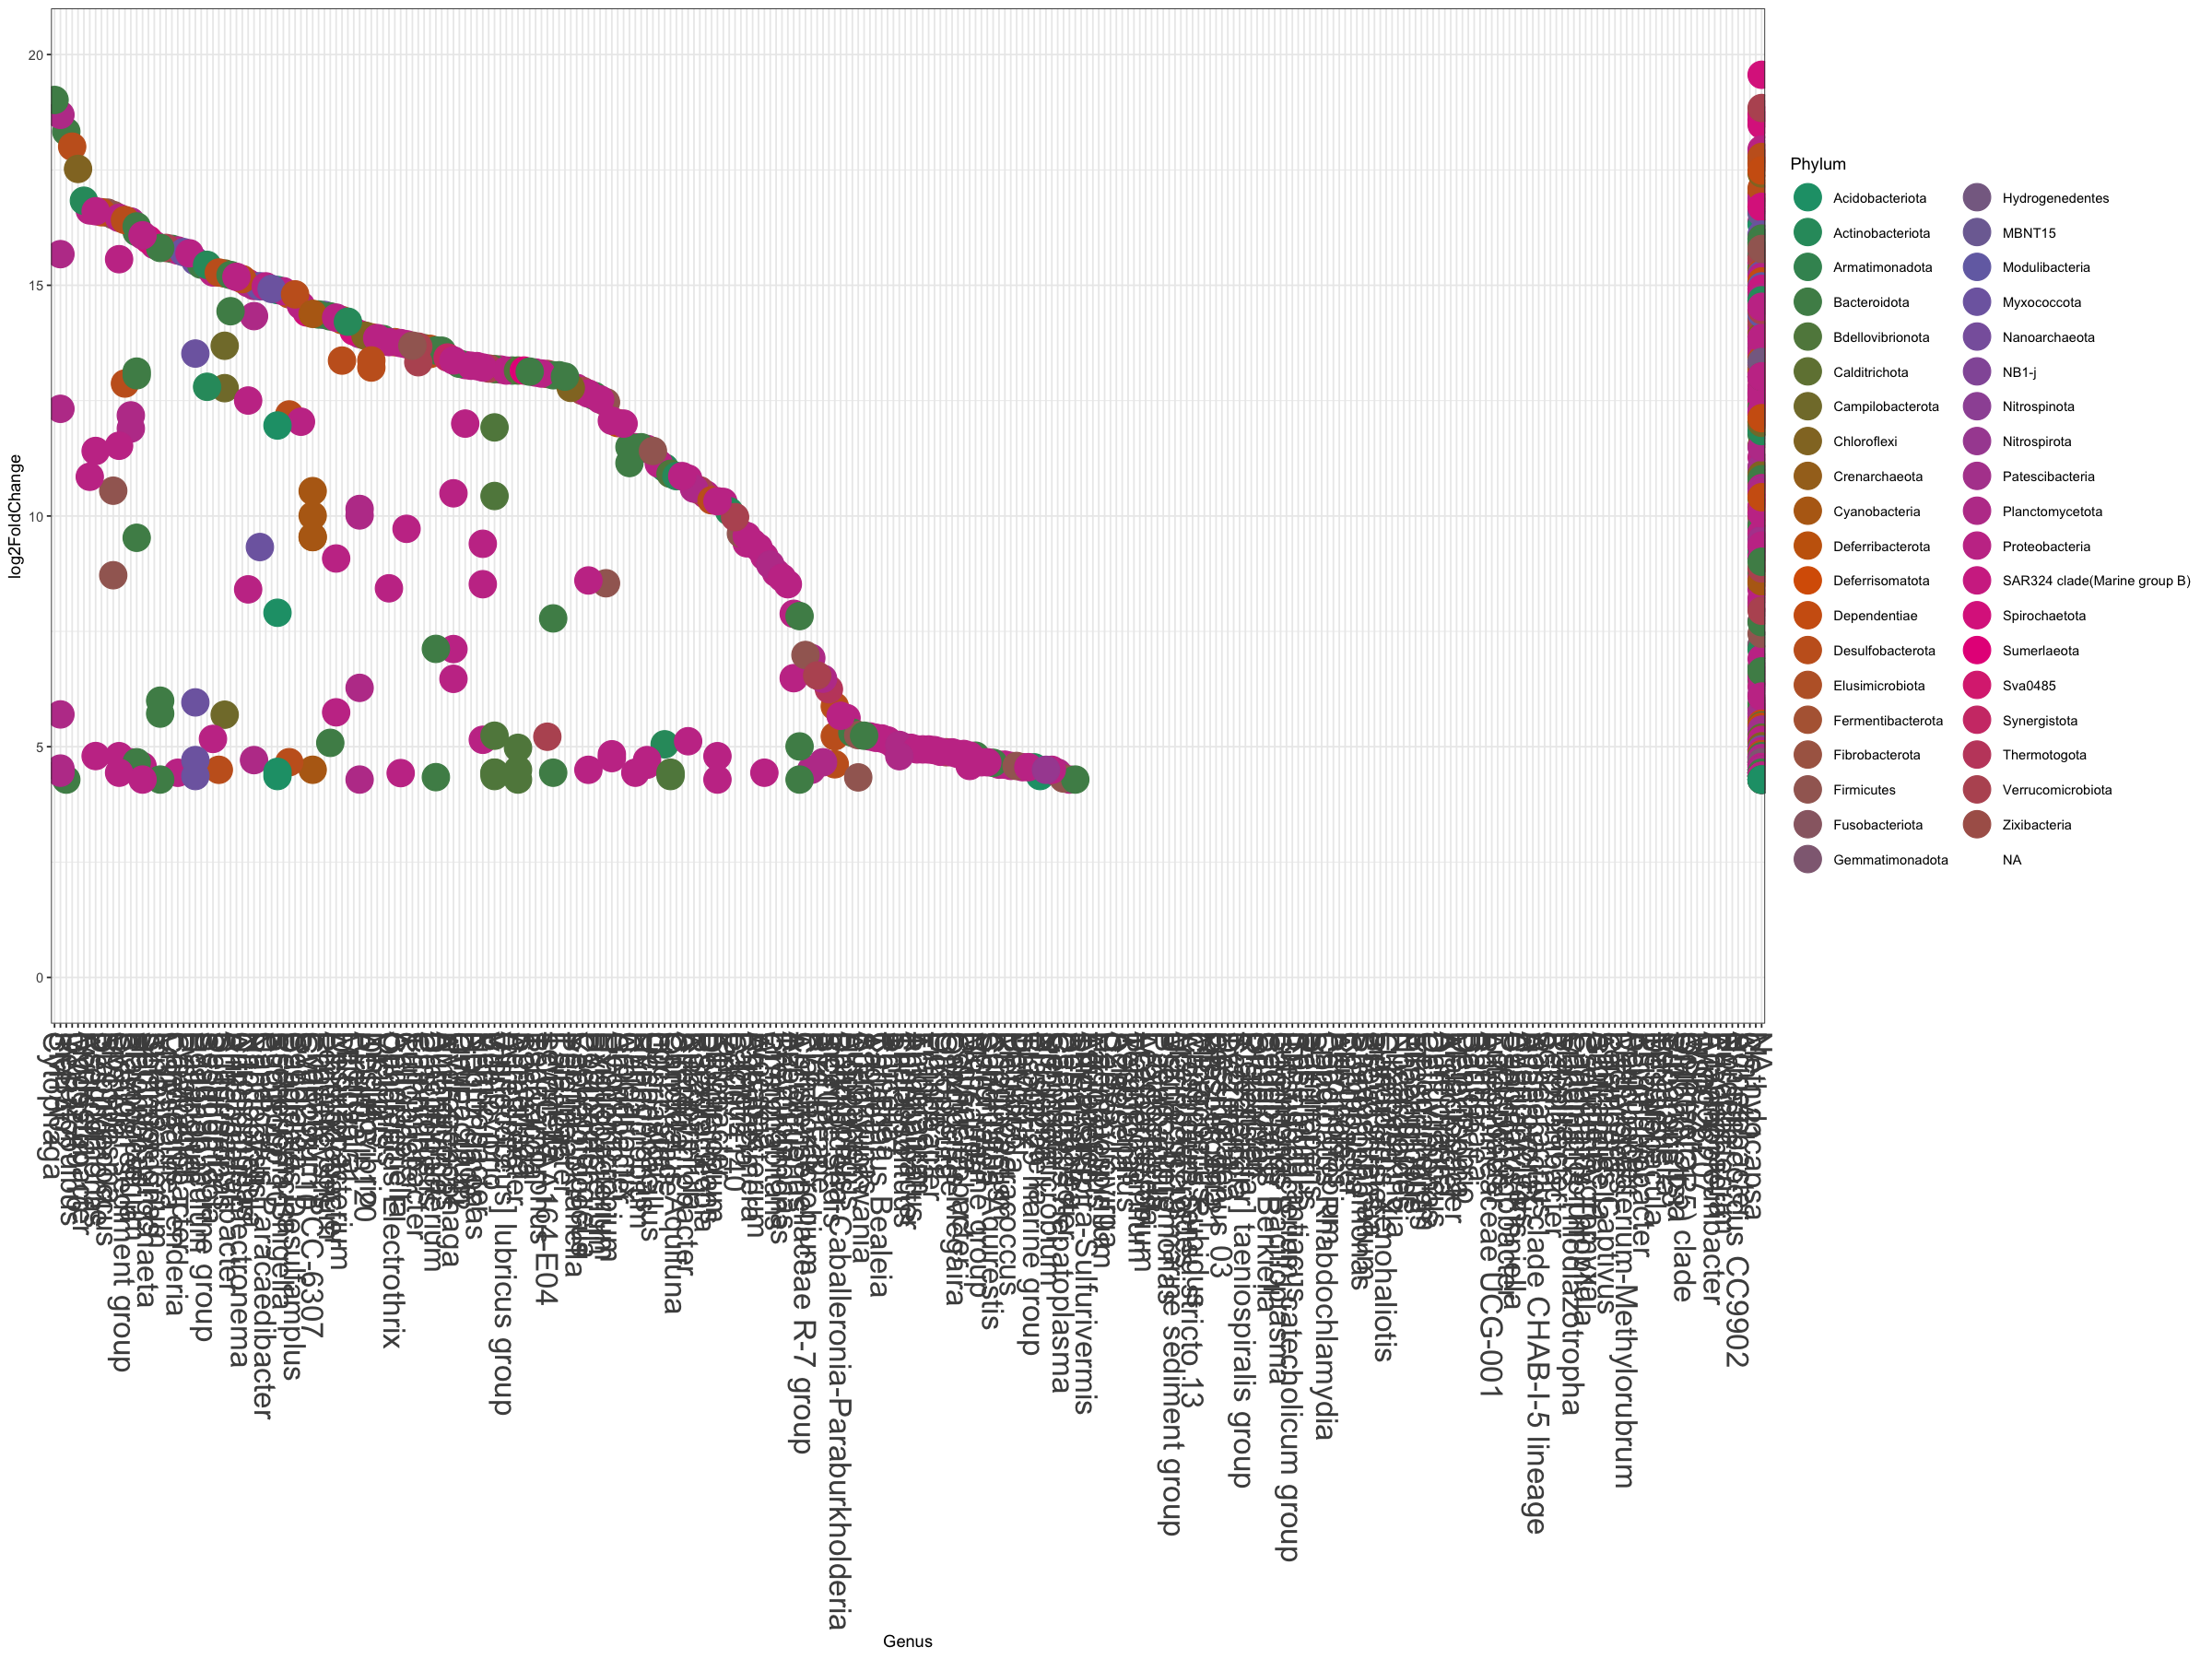

In [105]:

# Phylum order
x = tapply(sigtab$log2FoldChange, sigtab$Phylum, function(x) max(x))
x = sort(x, TRUE)
sigtab$Class = factor(as.character(sigtab$Phylum), levels=names(x))
# Genus order
x = tapply(sigtab$log2FoldChange, sigtab$Genus, function(x) max(x))
x = sort(x, TRUE)
sigtab$Genus = factor(as.character(sigtab$Genus), levels=names(x))
ggplot(sigtab, aes(x=Genus, y=log2FoldChange, color=Phylum)) + geom_point(size=8) + 
           scale_fill_manual(values=mycolors)+
scale_color_manual(values=mycolors)+
           ylim(0,20)+
  theme(axis.text.x = element_text(angle = -90, hjust = 0, vjust=0.5, size=20))

In [122]:
DE18_growthASVs=prune_taxa(DE18, taxa=highgrowthASVs)

In [281]:
DE18_growthASVs=transform_sample_counts(DE18_growthASVs, function(x) ifelse(x>=1, 1, 0))

In [287]:
proNums=as.data.frame(colSums(otu_table(DE18_growthASVs)))

In [289]:
samps=sample_data(DE18_growthASVs)

In [292]:
colnames(proNums)="proNum"

In [293]:
samps=merge(proNums, samps, by="row.names" )

In [ ]:
sa

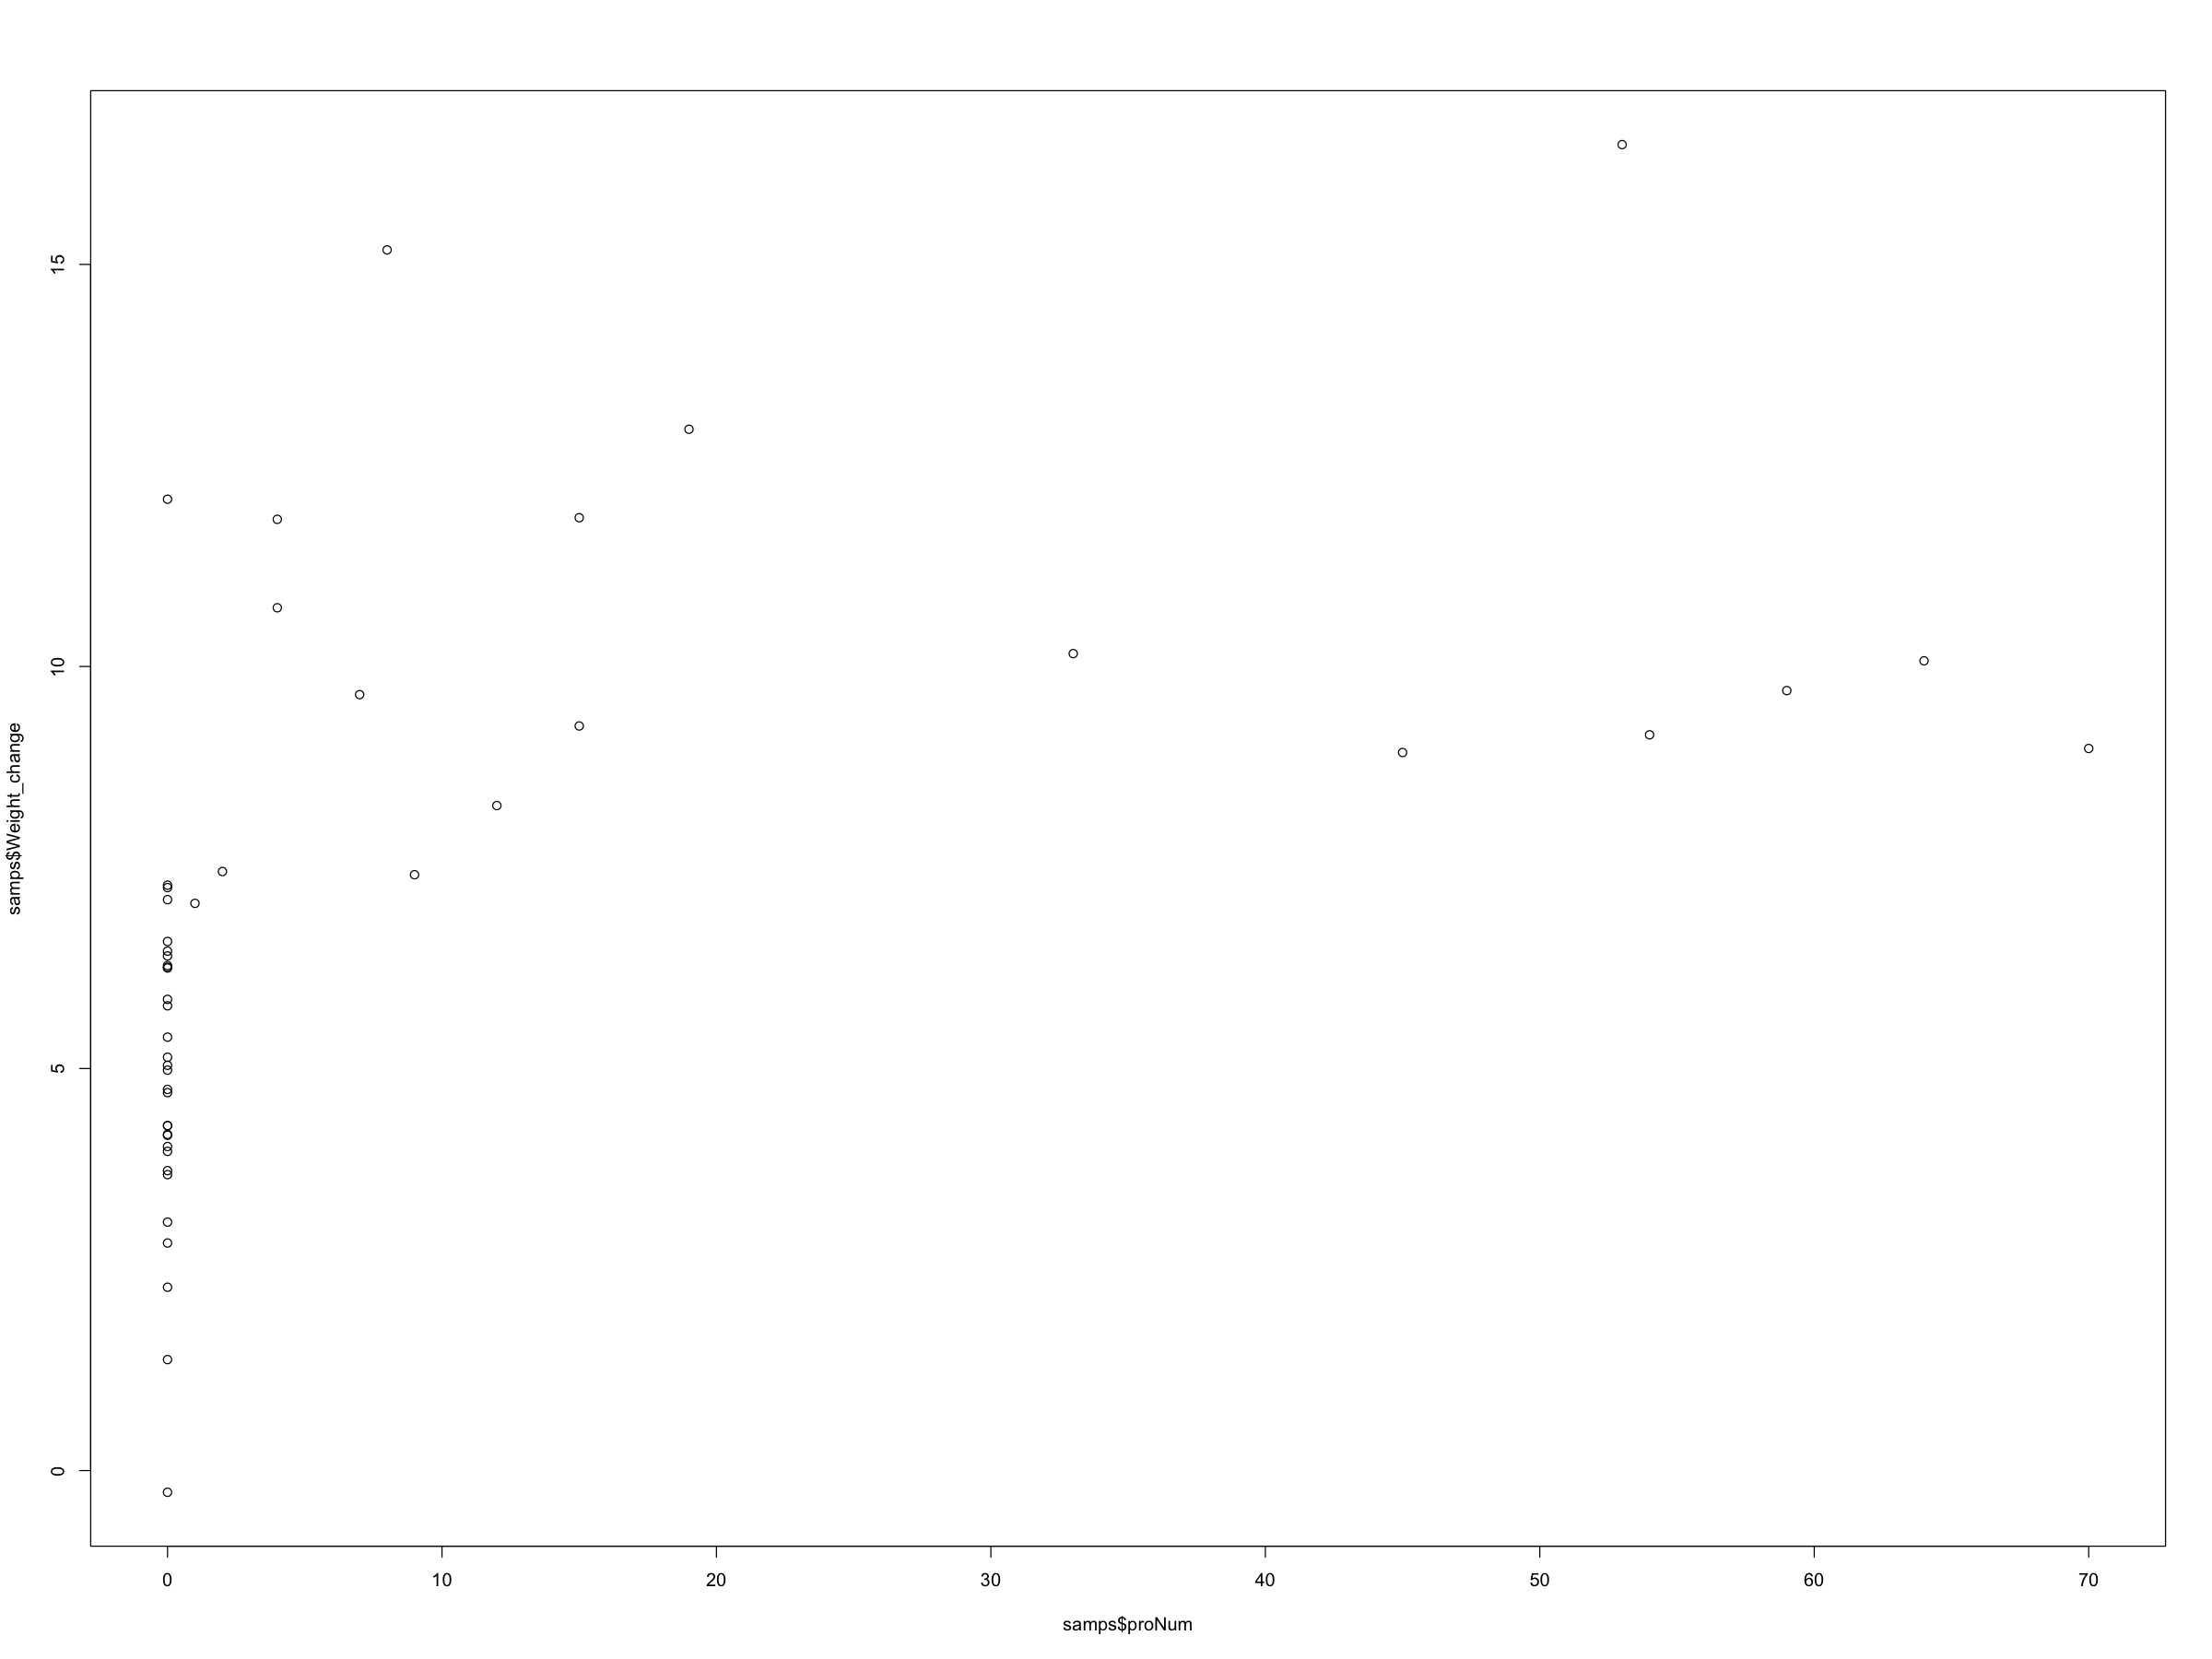

In [297]:
plot(samps$proNum, samps$Weight_change)

In [ ]:
OTU=transform_sample_counts(OTU, function(x) 1E6 * x/sum(x))

In [ ]:
rowsum(otu)

In [262]:
DE18ps=psmelt(DE18_growthASVs)

In [263]:
DE18ps=setorder(DE18ps, Weight_change)

In [274]:
DE18ps

OTU                                                                                                                                                                                                                                                                                                                                                
28    AACGTAGGACGCAAGCGTTATCCGGAGTTACTGGGCGTAAAGCGCGCGCAGGCGGACTGTTAAGTTAGCCATGAAAGCTCCCGGCTAAACTGGGAGAGGCTGGTTAAGACTGGCAGTCTTGAGTGAGTGAGAGGGAAGTGGAATTCCGCGTGTAGTGGTGAAATGCGTAGAGATGCGGAGGAACACCAGAGGCGAAGGCGGCTTCCTGGCACTCAACTGACGCTGAGGCGCGAAAGCATGGGTAGCGAACGGG                                                                                      
96    AACGTAGGACGCAAGCGTTATCCGGATTTACTGGGCGTAAAGCGCGTGCAGGCGGCCTGTTAAGTCGTGCGTGAAAGCTCCCTGGCTCAACCGGGAGAGGCCGTACGAAACTGGCAGGCTAGAGGGCAGCAGAGGAGTGTGGAATTCCGGGTGTAGTGGTGAAATGCGTAGATATCCGGAGGAACACCAGTGGCGAAGGCGGCACTCTGGGCTGTACCTGACGCTAAGACGCGAAAGCGTGGGTAGCGAACGGG                                                                                     
105   AACGTAGGACGCGAACGTTATCCGGAGTTACTGGGCGTAAAGCGCGAGCAGGCGGTTGAGTAAGTTACCTATGAAAGCTTCCGGCTAAACTGGGAGAGGATAGGTGATACTGCTGAACTAGAGTGAGAAAGAGGCAAGTAGAATTCCAGGTGTAGTGGTGAAATGCGTAGATATCTGGAGGAATACCAGTGGCGAAGGCGGCTTGCTGGTTCTCAACTGACGCTGAGACGCGAAAGCGTGGGTAGCGAACGGG                                                                                      
187   AACGTAGGACGCGAACGTTATCCGGAGTTACTGGGCGTAAAGCGCGTGCAGGCGGTTTTGTAAGTTACCTATGAAAGCTCTCGGCTAAACTGGGAGAGGATAGGTGAAACTGCAAGACTAGAGTGAGGTAGAGGTGAGTAGAATTCCAGGTGTAGTGGTGAAATGCGTAGATATCTGGAGGAATACCAGTGGCGAAGGCGGCTCACTGGCCCTCAACTGACGCTGAGACGCGAAAGCGTGGGTAGCGAACGGG                                                                                      
224   AACGTAGGAGGCAAGCGTTATCCGGATTTACTGGGCGTAAAGCGCGGGTAGGCGGCGATCTAAGTCATGCGTGAAAGCTCCCTGGCTCAACCGGGAGAGGTCGTGTGAGACTGGATTGCTTGAGGCAGGTAGAGGCTGACGGAATTCCGGGTGGAGTGGTGAAATGCGTAGAGATCCGGAGGAACACCAGTGGCGAAGGCGGTCAGCTGGGCCTAGCCTGACGCTCAGACGCGAAAGCATGGGGAGCGAACGGG                                                                                     
286   AACGTAGGAGGCGAGCGTTATCCGGATTTACTGGGCGTAAAGCGCGTGCAGGCGGTTTTCTAAGTCGGACGTGAAAGCTCCCGGCTCAACTGGGAGAGGTCGTTCGAAACTAGGAAACTTGAGGATGGTAGAGGAGAGTGGAATTCCCGGTGTAGTGGTGAAATGCGTAGATATCGGGAGGAACACCAGTGGCGAAGGCGGCTCTCTGGGCCATTCCTGACGCTAAGACGCGAAAGCTAGGGGAGAGAACGGG                                                                                      
333   AACGTAGGAGGCTAGCGTTATCCGGATTTATTGGGCGTAAAGCGCGTGCAGGCGGTCTGGTAAGTTGGATGTGAAAGCTCCTGGCTTAACTGGGAGAGGTCGTTCAATACTGTCAGACTAGAGAATGGGAGAGGGAGGTGGAATTCCGGGTGTAGTGGTGAAATGCGTAGATATCCGGAGGAACACCAGTGGCGAAAGCGGCCTCCTAGACCACTTCTGACGCTAAGACGCGAAAGCTAGGGTAGCAAACGGG                                                                                      
373   AACGTAGGGGCCAAGCGTTATCCGGAATTACTGGGCGTAAAGCGCATGCAGGCGGTTTTCTAAGTTGGACGTGAAAGCTCCCGGCTTAACTGGGAGAGGTCGTTCAATACTGGAAGACTTGAGGATGGTAGAGGAGAGTGGAATTCCCGGTGTAGTGGTGAAATGCGTAGATATCGGGAGGAACACCAGAGGCGAAGGCGGCTCTCTGGACCATTCCTGACGCTCAGATGCGAAAGCTAGGGGAGAGAACGGG                                                                                      
417   AACGTAGGGGCCGAGCGTTATCCGGATTTACTGGGCGTAAAGAGCATGTAGGCGGTTTTTTAAGTCGGACGTGAAAGCTCTCGGCTCAACTGAGAGAGGCCGTTCGAAACTAGAAGACTTGAGGATGGTAGAGGAGAGTGGAATTCCCGGTGTAGTGGTGAAATGCGTAGATATCGGGAGGAACACCAGTGGCGAAAGCGGCTCTCTGGACCATTCCTGACGCTGAGATGCGAAAGCTAGGGGAGAGAACGGG                                                                                      
483   ATACCGACTCCAAGAGTGTGTATGAGAGATGCTGCAGTTAAAAAGTCCGTAGTCATAGAAGCGAAAACAGGGACGAGGTCTCGGGACTGAGTGGTGGAGGAGCCGATGGGGAACATAGTATACCAGGGCGAGAGATGAAATGCCAAGACCCCTGGTGGACTGAGCGAGGCGAAAGCGATGTTCTTGTAGGAGTCCGGTGATCAAGGACGAAGGCTGGAGTATCGAAAGTGATTAGAAACCCCAGTAGTCCA                                                                                        
496   CACCAGCGCCACAAGTGGCAACCGGAATTATTGGGCCTAAAGCGTTCGTAGCCTGTTATGTAAATCTTTTGTGAAATTGTCTAGCTTAACTAGTCAGATTGCAGAAGAGACTGCATAACTTGGGACCGGAAGGGGTTAGGAGTATTTTGGGGGGAGCGGTAAAATGTTATAATCCTCAAAAGACTACCTGTGGC

Warning message in RColorBrewer::brewer.pal(n, pal):
“n too large, allowed maximum for palette Dark2 is 8
Returning the palette you asked for with that many colors
”


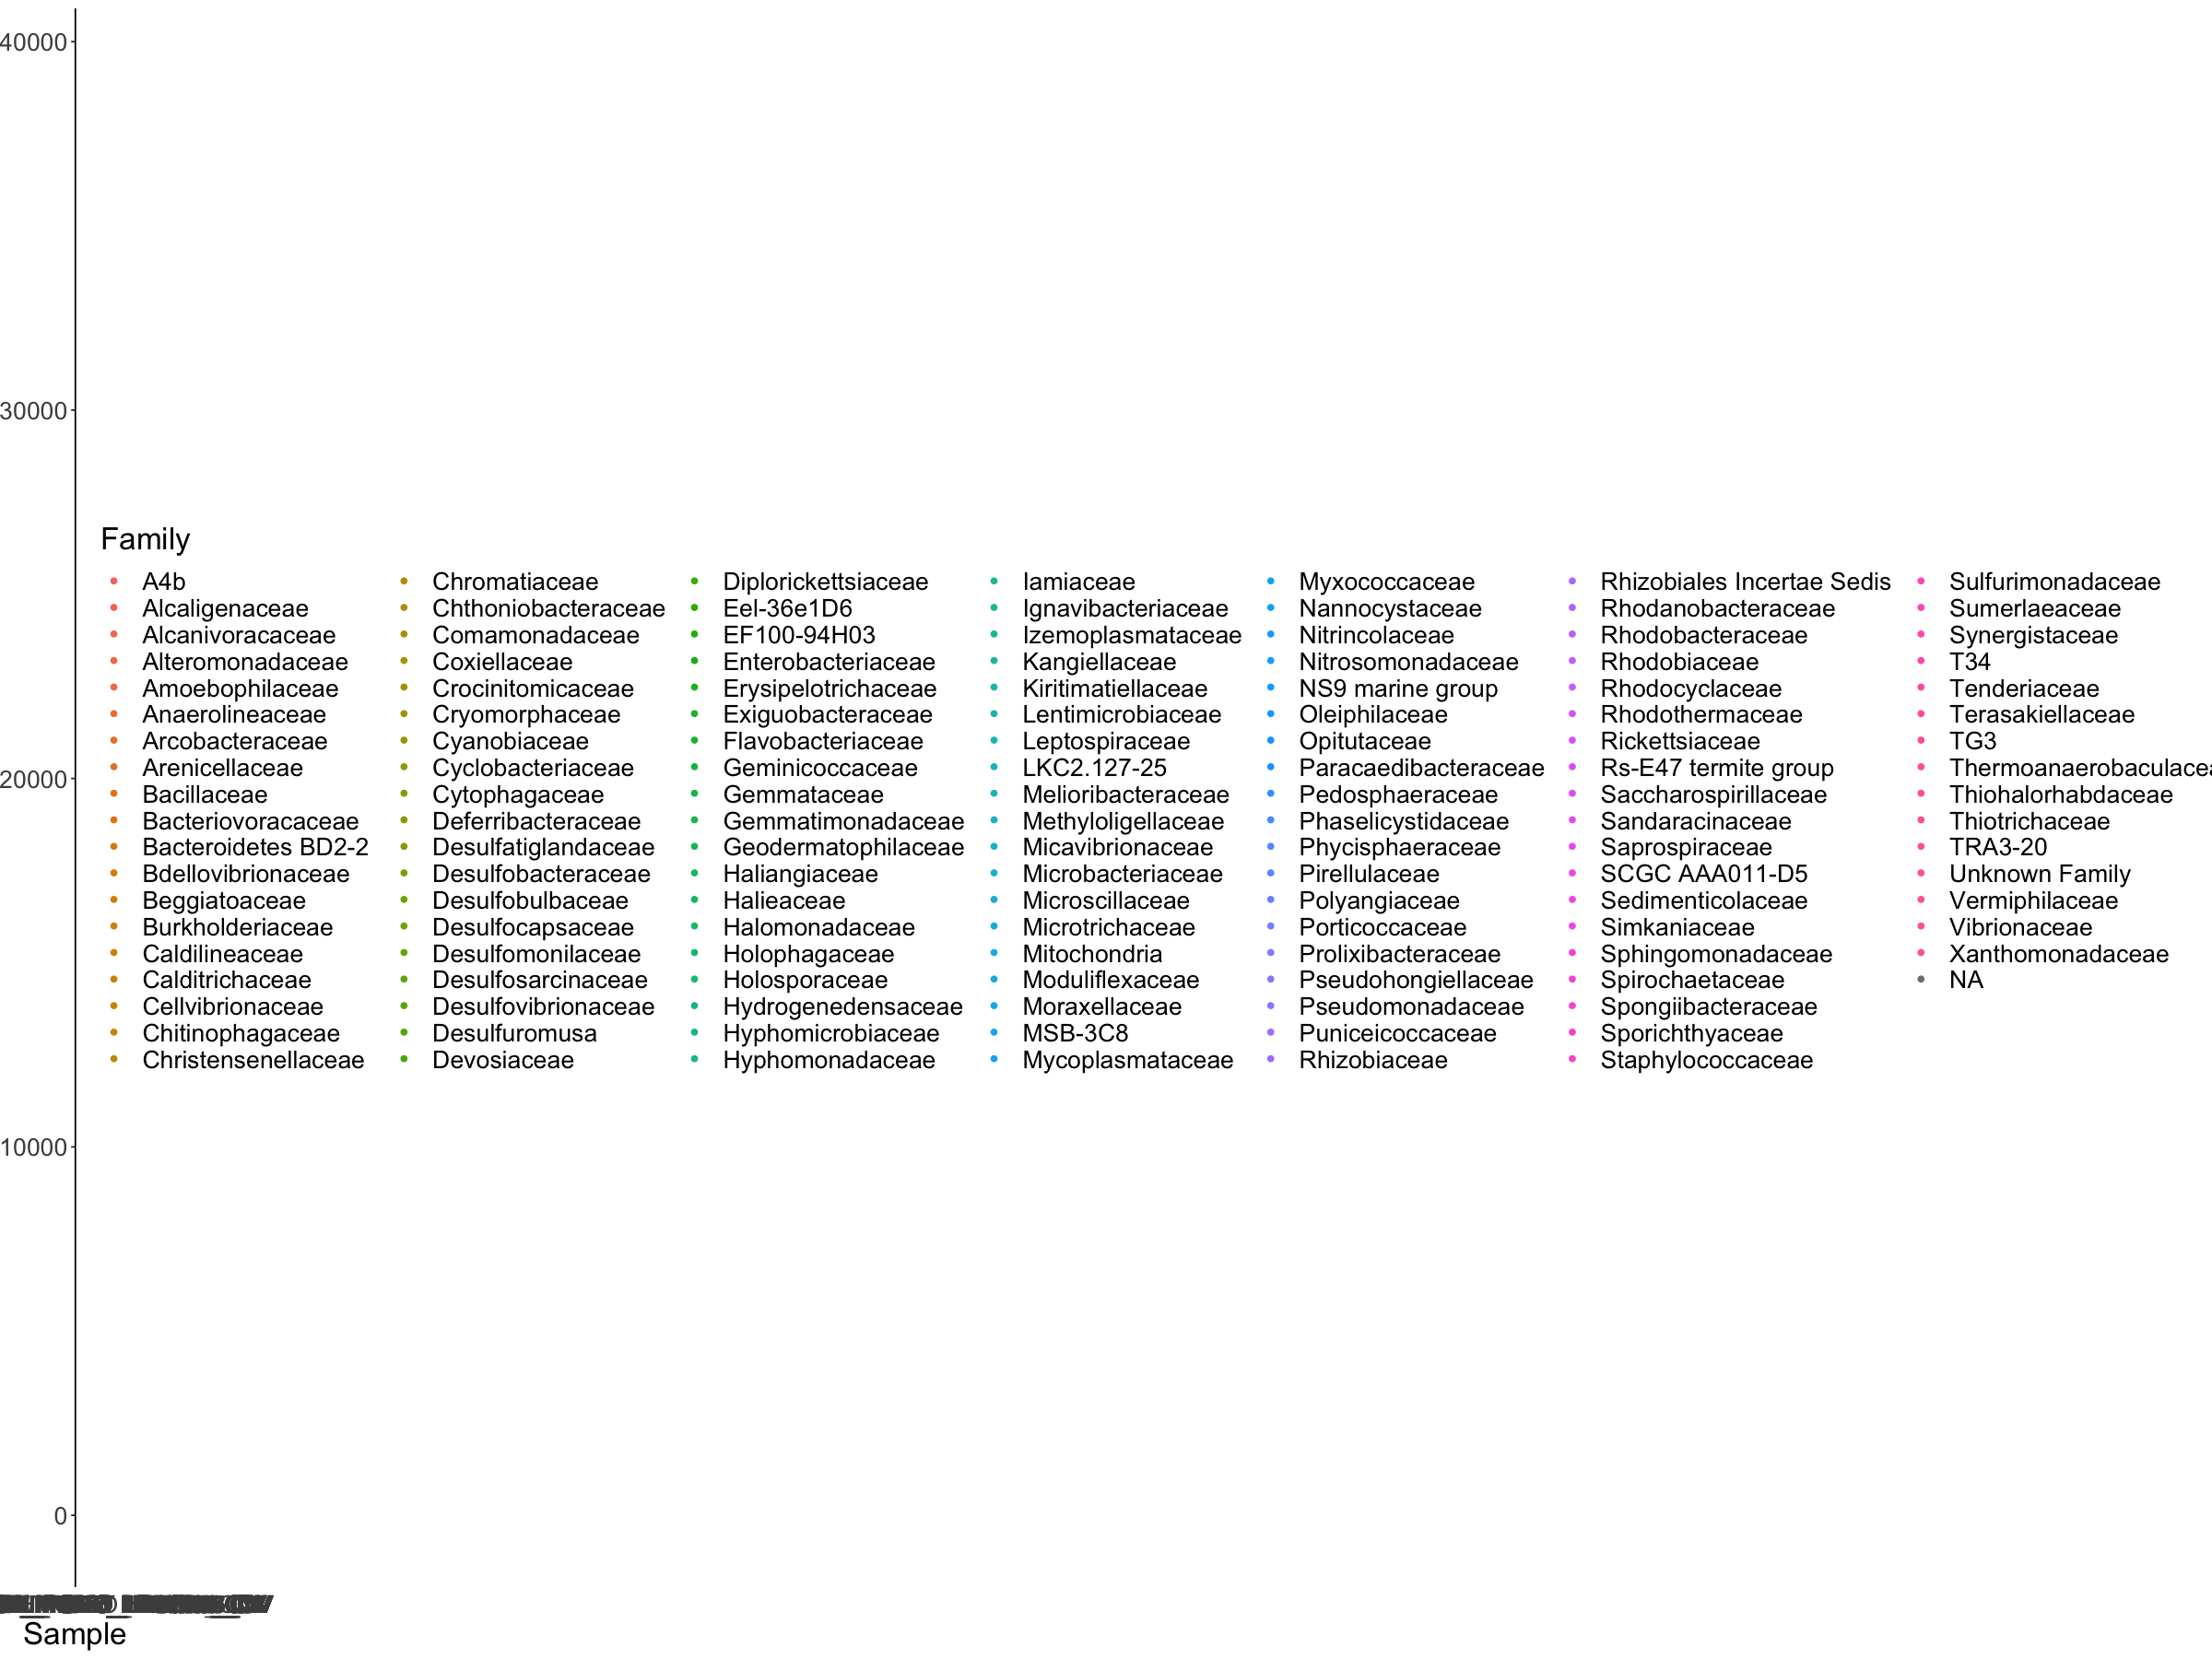

In [265]:
ggplot(DE18ps,  fill="Family") +
geom_point(aes(x=Sample, y=Abundance, color=Family, fill=Family))+
#scale_fill_manual(values=mycolors)+
#scale_color_manual(values=mycolors)+
theme_bw()+
theme(legend.position="right", panel.border = element_blank(), 
          panel.grid.major.x = element_blank(), 
          panel.grid.minor.x = element_blank(),
          axis.ticks.x=element_blank(), axis.line=element_line(color="black"), 
         text = element_text(size=20))

In [124]:
ggplot(DE18_growthASVs, aes(x=Abundance, y=Weight_change, color=Species))+
geom_point(aes(fill=Species), size=8)+
facet_grid(.~Treatment2_Diversity)+
theme_bw()+
geom_text(aes(label=Number), color="black", size=8)+
theme(legend.position = "none", text = element_text(size=20), axis.text.x = element_text(angle = 90))


ERROR: Error: `data` must be a data frame, or other object coercible by `fortify()`, not an S4 object with class phyloseq


In [126]:
newtab = data.table(pTime$data)
setorder(newtab, TIMEPOINT_NUMBER)
pTime$data <- newtab

Warning message in is.na(x):
“is.na() applied to non-(list or vector) of type 'S4'”


ERROR: Error in x[!nas]: object of type 'S4' is not subsettable


In [160]:
p=plot_bar(DE18_growthASVs,  fill="Phylum") 

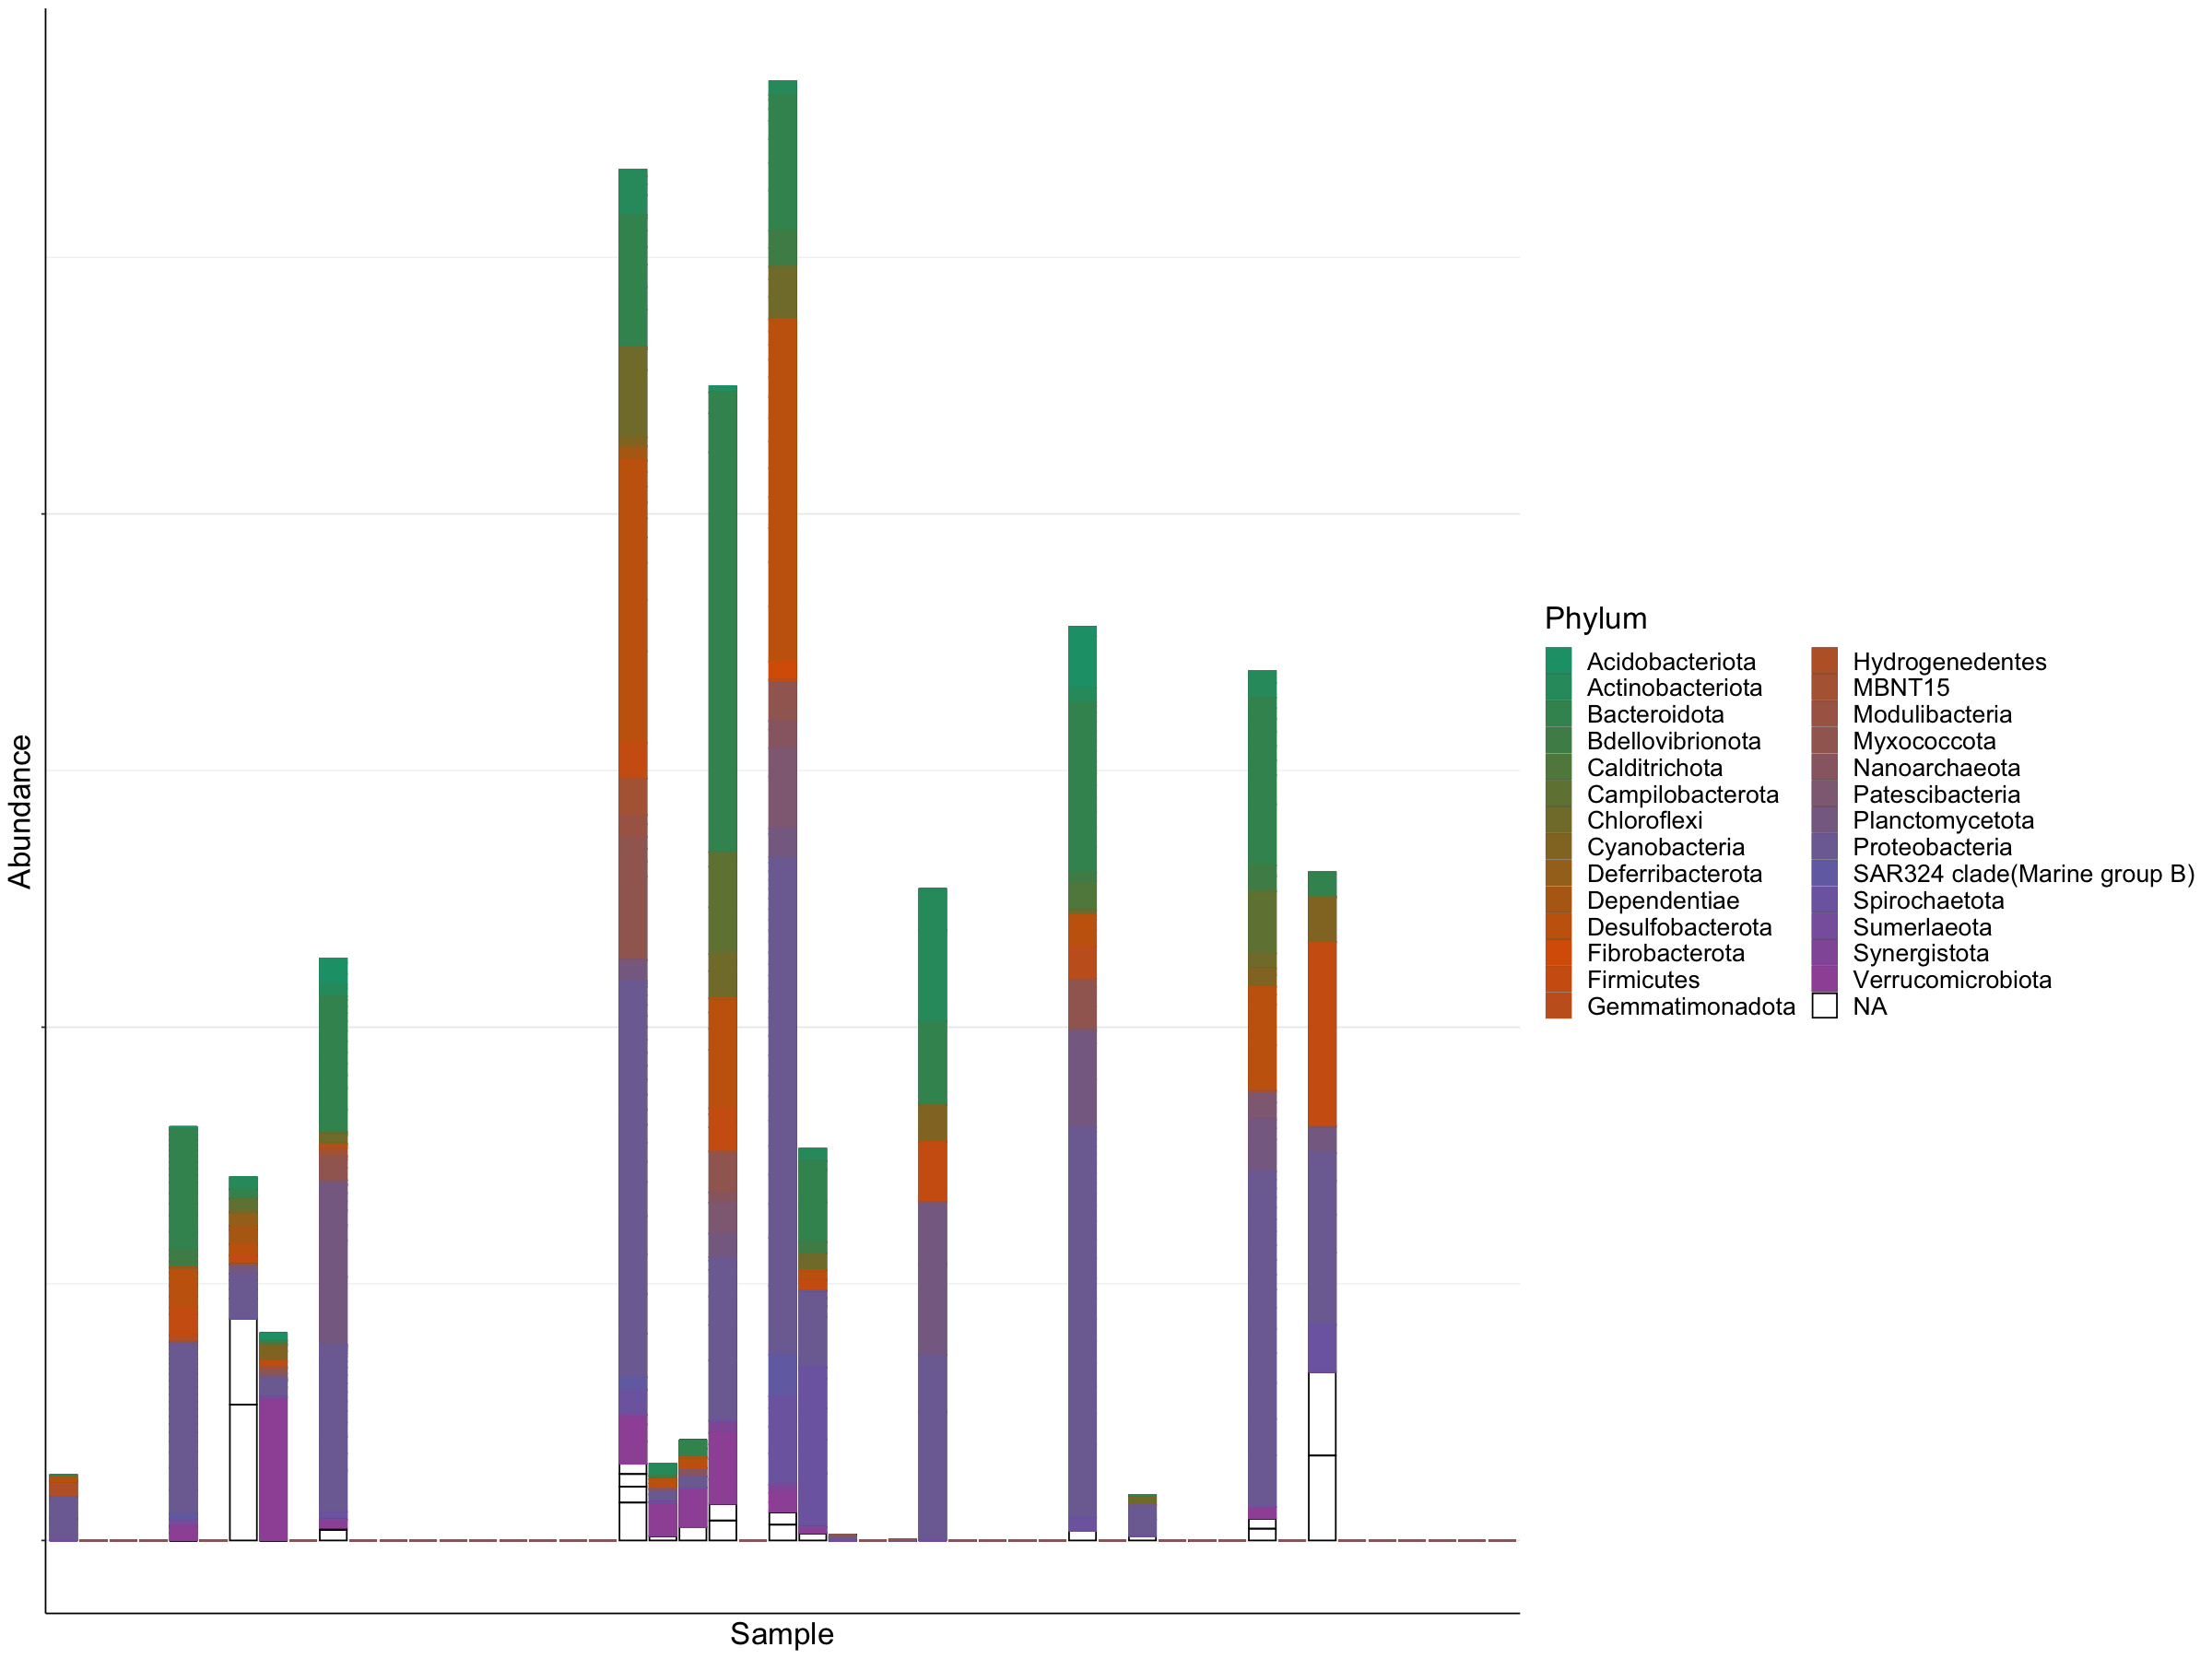

In [161]:
p+geom_bar(aes(x = reorder(Sample, Weight_change), color=Phylum, fill=Phylum), stat="identity", position="stack")+
scale_fill_manual(values=mycolors)+
scale_color_manual(values=mycolors)+
theme_bw()+
theme(legend.position="right", panel.border = element_blank(), 
          panel.grid.major.x = element_blank(), 
          panel.grid.minor.x = element_blank(),
          axis.ticks.x=element_blank(), axis.line=element_line(color="black"), 
          axis.text=element_blank(), text = element_text(size=20))

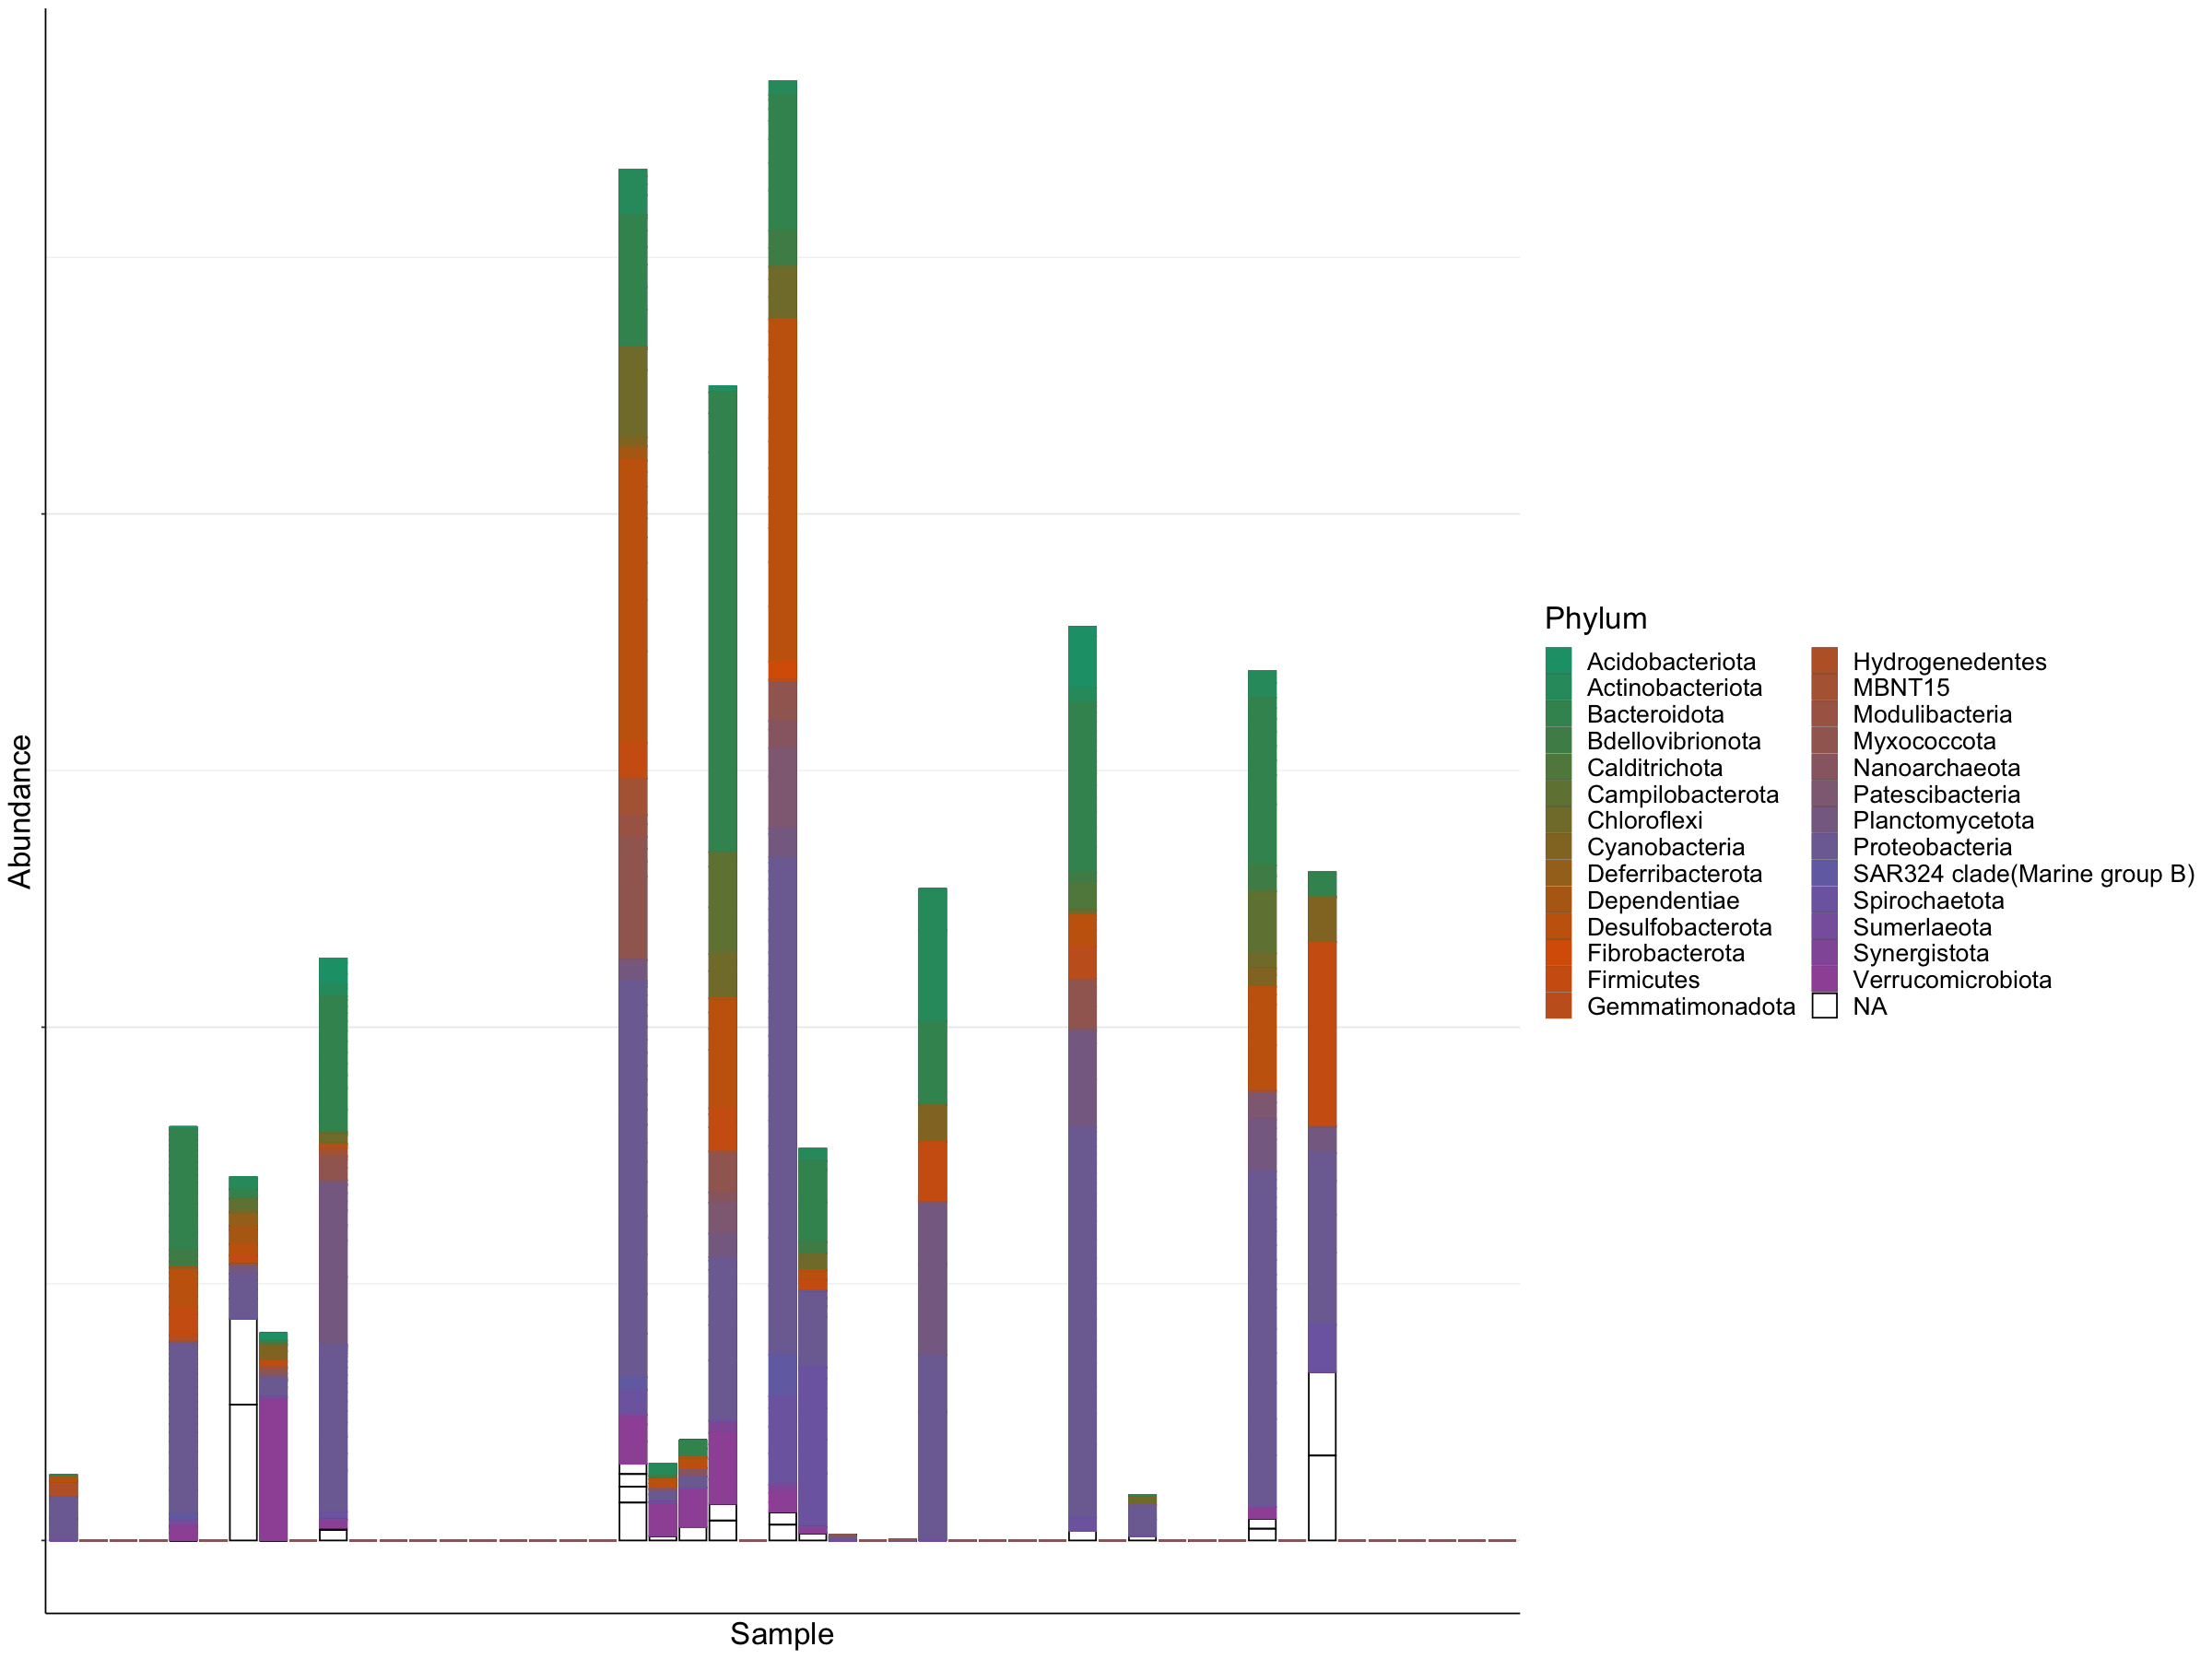

In [159]:
p

In [151]:
newtab = data.table(p$data)
setorder(newtab, Weight_change)
p$data <- newtab

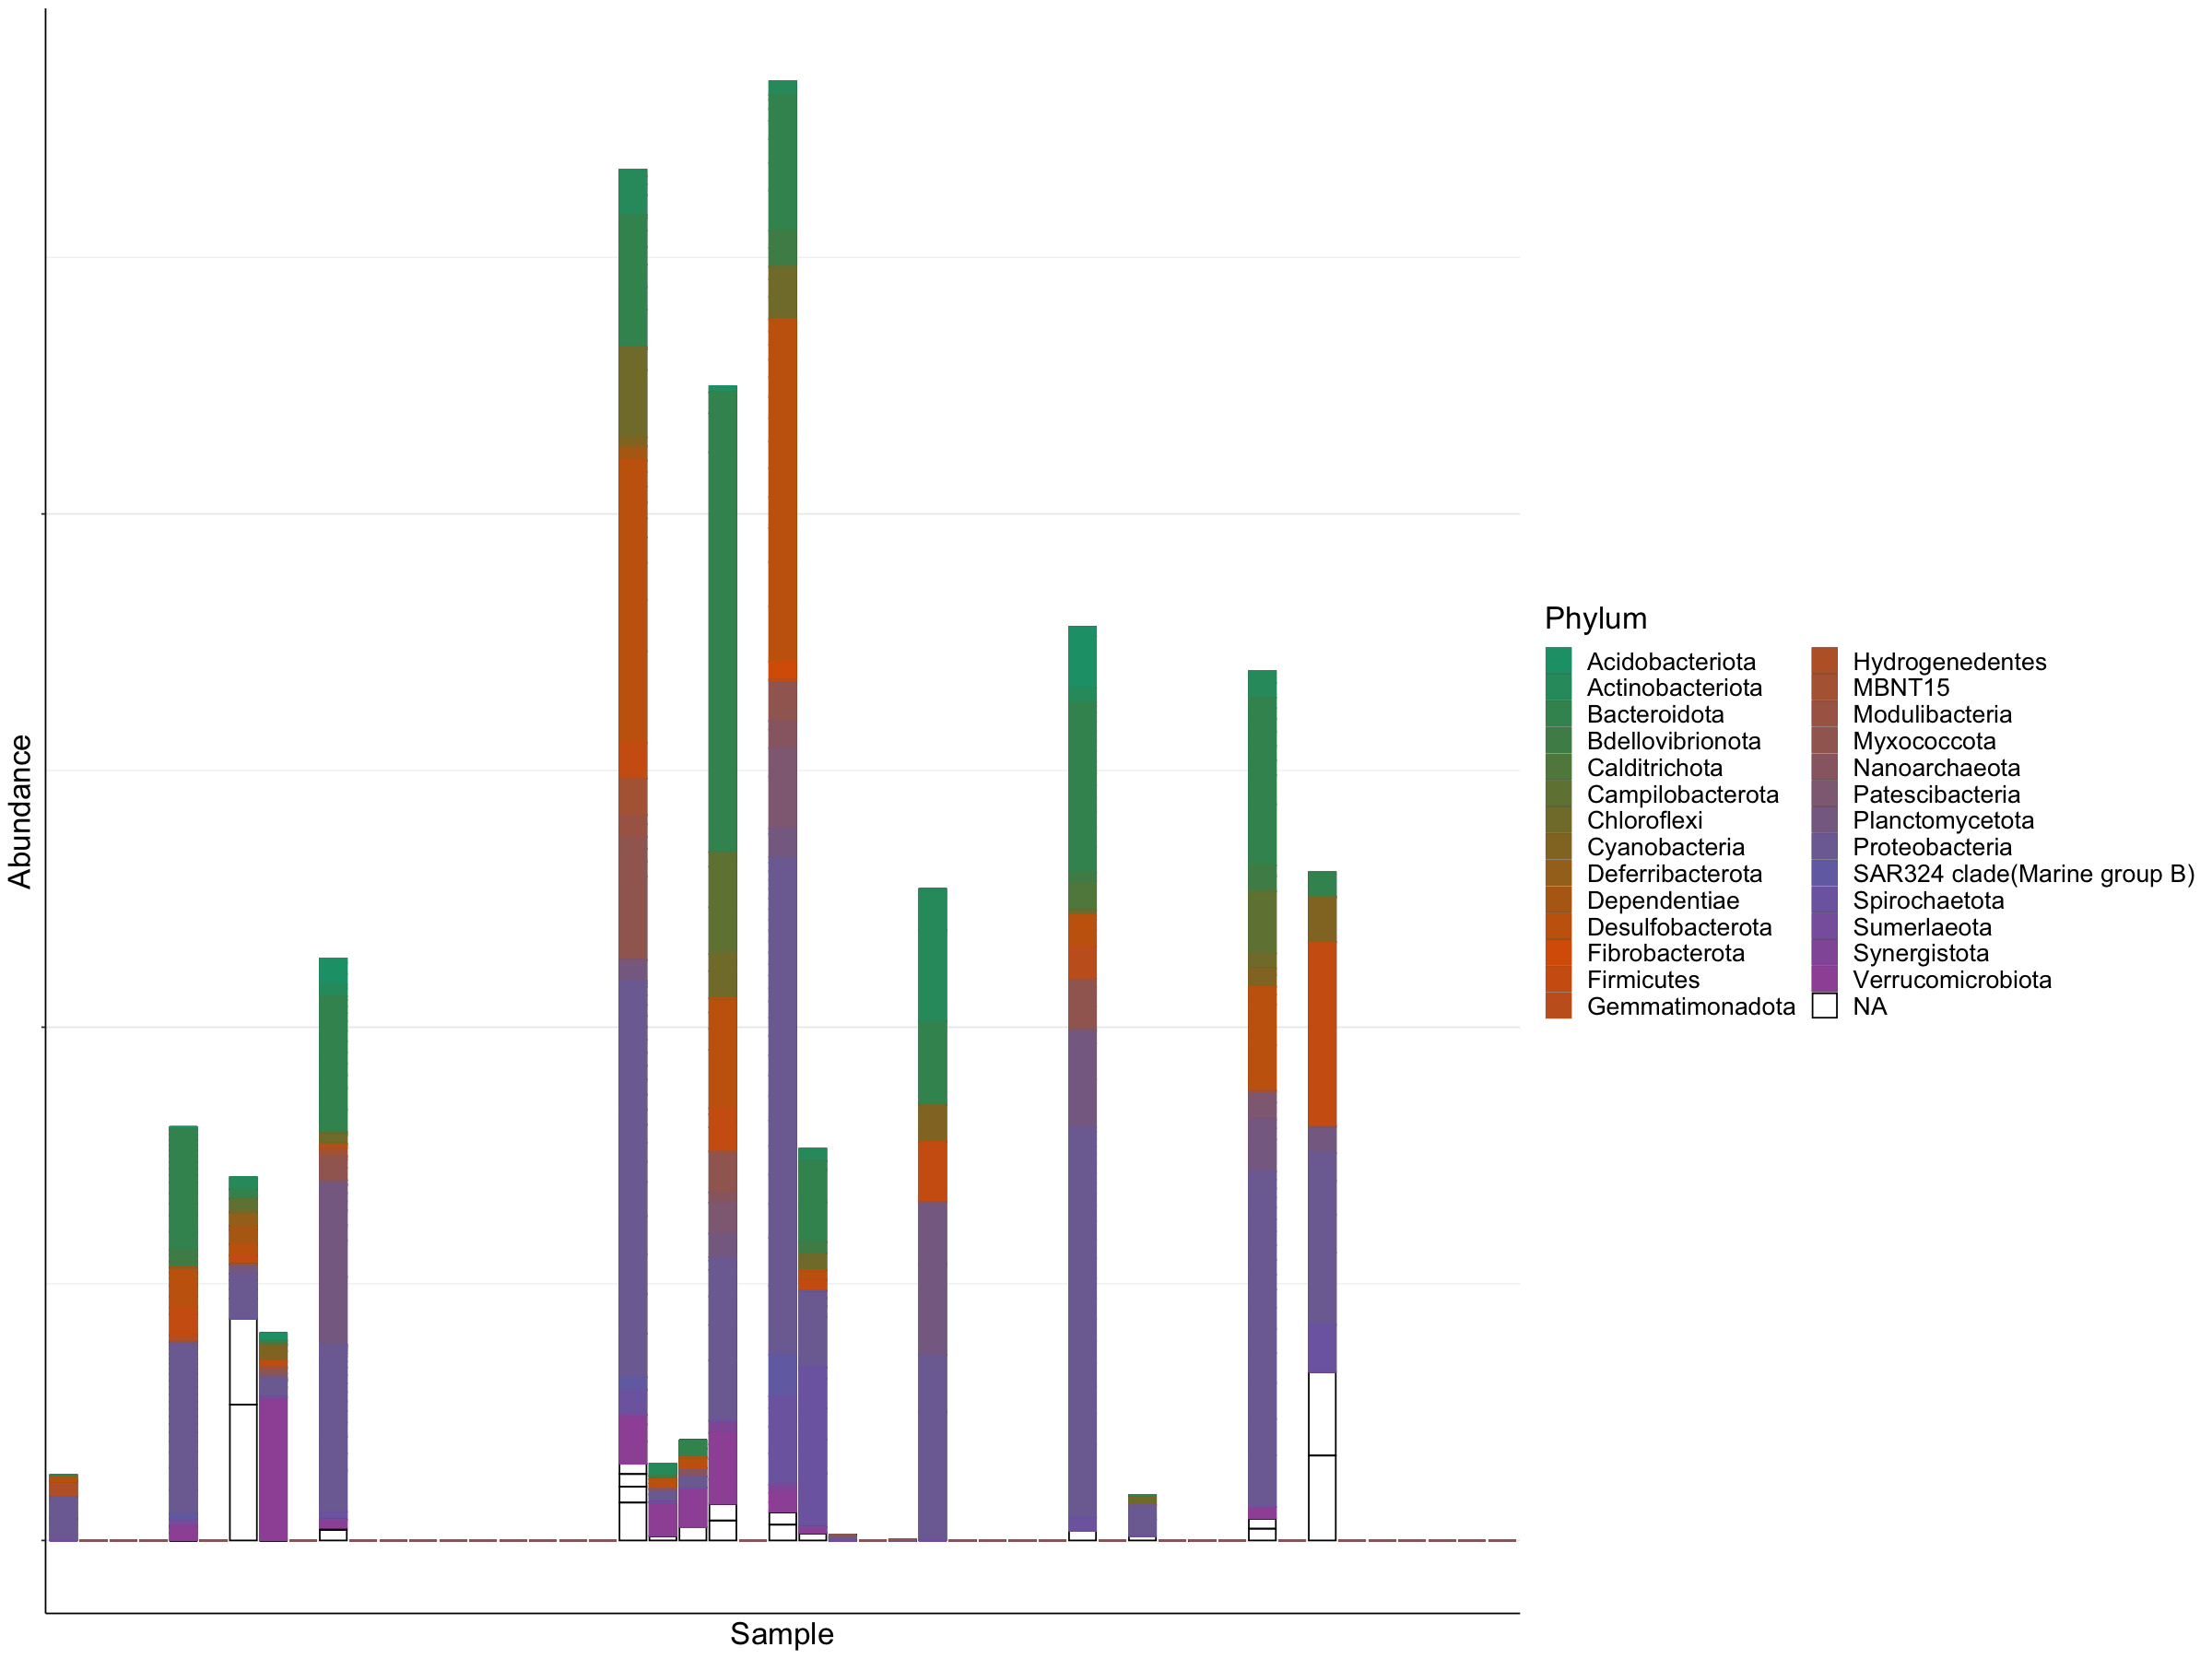

In [154]:
ggplot(tips2, aes(x = reorder(day, -perc), y = perc)) + geom_bar(stat = "identity")
